In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from registration_utilities import *
from annotation_utilities import *
from metadata import *
from data_manager import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for AWS compute node


No vtk


In [3]:
# stack_fixed = 'LM30'
stack_fixed = 'LM40'
stack_moving = 'atlasV5'

# Global

In [80]:
# warp_setting = 20
warp_setting = 16
# Adding surr is essential.

In [81]:
registration_settings = read_csv(REGISTRATION_SETTINGS_CSV, header=0, index_col=0)
registration_settings

,upstream_warp_id,transform_type,terminate_thresh,grad_computation_sample_number,grid_search_sample_number,std_tx_um,std_ty_um,std_tz_um,std_theta_xy_degree,surround_weight,regularization_weight,comment
warp_id,,,,,,,,,,,,
1,None,affine,0.000010,100000.0,1000.0,2000,2000,2000,30,0,NaN,NaN
2,1,rigid,0.000010,100000.0,10000.0,100,100,100,30,0,NaN,NaN
4,1,rigid,0.000001,100000.0,10000.0,100,100,100,10,0,0.000001,NaN
5,1,rigid,0.000001,100000.0,10000.0,100,100,100,30,inverse,0.000000,NaN
6,1,affine,0.000010,100000.0,10000.0,100,100,100,30,-0.5,0.000000,NaN
7,None,rigid,0.000001,100000.0,1000.0,50,50,50,10,0,NaN,NaN
8,None,rigid,0.000001,100000.0,10000.0,200,200,200,30,inverse,0.000000,align mid-sagittal planes
9,8,rigid,0.000001,100000.0,10000.0,2000,2000,2000,30,NaN,NaN,global registration given mid-sagittal planes ...
18,8,affine,0.000001,100000.0,10000.0,200,200,200,30,NaN,NaN,global registration given mid-sagittal planes ...


In [82]:
warp_properties = registration_settings.loc[warp_setting]
print warp_properties

upstream_warp_setting = warp_properties['upstream_warp_id']
if upstream_warp_setting == 'None':
    upstream_warp_setting = None
transform_type = warp_properties['transform_type']
terminate_thresh = warp_properties['terminate_thresh']
grad_computation_sample_number = int(warp_properties['grad_computation_sample_number'])
grid_search_sample_number = warp_properties['grid_search_sample_number']
std_tx_um = warp_properties['std_tx_um']
std_ty_um = warp_properties['std_ty_um']
std_tz_um = warp_properties['std_tz_um']
std_tx = std_tx_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_ty = std_ty_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_tz = std_tz_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_theta_xy = np.deg2rad(warp_properties['std_theta_xy_degree'])
print std_tx, std_ty, std_tz, std_theta_xy

surround_weight = warp_properties['surround_weight']
if isinstance(surround_weight, float) or isinstance(surround_weight, int):
    surround_weight = float(surround_weight)
    include_surround = surround_weight != 0 and not np.isnan(surround_weight)
elif isinstance(surround_weight, str):
    surround_weight = str(surround_weight)
    # Setting surround_weight as inverse is very important. Using -1 often gives false peaks.
    include_surround = True

upstream_warp_id                                  None
transform_type                                  affine
terminate_thresh                                 1e-05
grad_computation_sample_number                  100000
grid_search_sample_number                         1000
std_tx_um                                         2000
std_ty_um                                         2000
std_tz_um                                         2000
std_theta_xy_degree                                 30
surround_weight                                inverse
regularization_weight                              NaN
comment                           global reg with surr
Name: 16, dtype: object
135.869565217 135.869565217 135.869565217 0.523598775598


In [83]:
MAX_ITER_NUM = 1000
HISTORY_LEN = 20
MAX_GRID_SEARCH_ITER_NUM = 30

lr1 = 10
lr2 = 0.1

In [84]:
volume_moving, structure_to_label_moving, label_to_structure_moving = \
DataManager.load_original_volume_all_known_structures(stack=stack_moving, sided=True, volume_type='score', 
                                                      include_surround=include_surround)
print volume_moving[1].shape

Prior structure/index map not found. Generating a new one.


rm -rf "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_outerContour.bp" && mkdir -p "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_outerContour.bp" "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_outerContour.bp"


File does not exist: /shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_outerContour.bp
Score volume for outerContour does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_outerContour.bp'


rm -rf "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_outerContour_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_outerContour_surround_200.bp" "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_outerContour_surround_200.bp"


File does not exist: /shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_outerContour_surround_200.bp
Score volume for outerContour_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_outerContour_surround_200.bp'


rm -rf "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_sp5.bp" && mkdir -p "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_sp5.bp" "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_sp5.bp"


File does not exist: /shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_sp5.bp
Score volume for sp5 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_sp5.bp'


rm -rf "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_sp5_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_sp5_surround_200.bp" "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_sp5_surround_200.bp"
(356, 427, 375)


File does not exist: /shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_sp5_surround_200.bp
Score volume for sp5_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_sp5_surround_200.bp'
Volume shape: (356, 427, 375)


In [85]:
volume_fixed, structure_to_label_fixed, label_to_structure_fixed = \
DataManager.load_original_volume_all_known_structures(stack=stack_fixed, sided=True, 
                                                      volume_type='annotationAsScore',
                                                     include_surround=include_surround)

print volume_fixed[1].shape

Prior structure/index map not found. Generating a new one.


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_L.bp
Score volume for 10N_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_L_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_L_surround_200.bp
Score volume for 10N_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_R.bp
Score volume for 10N_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_R_surround_200.bp
Score volume for 10N_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_12N.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_12N.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_12N.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_12N.bp
Score volume for 12N does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_12N.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_12N_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_12N_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_12N_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_12N_surround_200.bp
Score volume for 12N_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_12N_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_3N_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_3N_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_3N_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_3N_R.bp
Score volume for 3N_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_3N_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_3N_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_3N_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_3N_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_3N_R_surround_200.bp
Score volume for 3N_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_3N_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_L.bp
Score volume for 4N_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_L_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_L_surround_200.bp
Score volume for 4N_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_R.bp
Score volume for 4N_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_R_surround_200.bp
Score volume for 4N_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_L.bp
Score volume for 5N_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_L_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_L_surround_200.bp
Score volume for 5N_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_R.bp
Score volume for 5N_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_R_surround_200.bp
Score volume for 5N_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_L.bp
Score volume for 6N_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_L_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_L_surround_200.bp
Score volume for 6N_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_R.bp
Score volume for 6N_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_R_surround_200.bp
Score volume for 6N_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_L.bp
Score volume for 7N_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_L_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_L_surround_200.bp
Score volume for 7N_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_R.bp
Score volume for 7N_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_R_surround_200.bp
Score volume for 7N_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_L.bp
Score volume for 7n_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_L_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_L_surround_200.bp
Score volume for 7n_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_R.bp
Score volume for 7n_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_R_surround_200.bp
Score volume for 7n_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_AP.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_AP.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_AP.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_AP.bp
Score volume for AP does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_AP.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_AP_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_AP_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_AP_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_AP_surround_200.bp
Score volume for AP_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_AP_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_L.bp
Score volume for Amb_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_L_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_L_surround_200.bp
Score volume for Amb_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_R.bp
Score volume for Amb_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_R_surround_200.bp
Score volume for Amb_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_L.bp
Score volume for DC_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_L_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_L_surround_200.bp
Score volume for DC_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_R.bp
Score volume for DC_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_R_surround_200.bp
Score volume for DC_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_IC.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_IC.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_IC.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_IC.bp
Score volume for IC does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_IC.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_IC_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_IC_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_IC_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_IC_surround_200.bp
Score volume for IC_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_IC_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_L.bp
Score volume for LC_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_L_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_L_surround_200.bp
Score volume for LC_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_R.bp
Score volume for LC_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_R_surround_200.bp
Score volume for LC_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_L.bp
Score volume for LRt_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_L_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_L_surround_200.bp
Score volume for LRt_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_R.bp
Score volume for LRt_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_R_surround_200.bp
Score volume for LRt_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_L.bp
Score volume for PBG_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_L_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_L_surround_200.bp
Score volume for PBG_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_R.bp
Score volume for PBG_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_R_surround_200.bp
Score volume for PBG_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_L.bp
Score volume for Pn_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_L_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_L_surround_200.bp
Score volume for Pn_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_R.bp
Score volume for Pn_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_R_surround_200.bp
Score volume for Pn_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RMC_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RMC_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RMC_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RMC_R.bp
Score volume for RMC_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RMC_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RMC_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RMC_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RMC_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RMC_R_surround_200.bp
Score volume for RMC_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RMC_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RtTg.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RtTg.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RtTg.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RtTg.bp
Score volume for RtTg does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RtTg.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RtTg_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RtTg_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RtTg_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RtTg_surround_200.bp
Score volume for RtTg_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RtTg_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SC.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SC.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SC.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SC.bp
Score volume for SC does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SC.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SC_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SC_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SC_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SC_surround_200.bp
Score volume for SC_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SC_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_L.bp
Score volume for SNC_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_L_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_L_surround_200.bp
Score volume for SNC_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_R.bp
Score volume for SNC_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_R_surround_200.bp
Score volume for SNC_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNR_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNR_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNR_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNR_R.bp
Score volume for SNR_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNR_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNR_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNR_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNR_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNR_R_surround_200.bp
Score volume for SNR_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNR_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_L.bp
Score volume for Sp5C_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_L_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_L_surround_200.bp
Score volume for Sp5C_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_R.bp
Score volume for Sp5C_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_R_surround_200.bp
Score volume for Sp5C_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_L.bp
Score volume for Sp5I_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_L_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_L_surround_200.bp
Score volume for Sp5I_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_R.bp
Score volume for Sp5I_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_R_surround_200.bp
Score volume for Sp5I_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_L.bp
Score volume for Sp5O_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_L_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_L_surround_200.bp
Score volume for Sp5O_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_R.bp
Score volume for Sp5O_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_R_surround_200.bp
Score volume for Sp5O_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_L.bp
Score volume for Tz_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_L_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_L_surround_200.bp
Score volume for Tz_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_R.bp
Score volume for Tz_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_R_surround_200.bp
Score volume for Tz_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_L.bp
Score volume for VCA_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_L_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_L_surround_200.bp
Score volume for VCA_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_R.bp
Score volume for VCA_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_R_surround_200.bp
Score volume for VCA_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_L.bp
Score volume for VCP_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_L_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_L_surround_200.bp
Score volume for VCP_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_R.bp
Score volume for VCP_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_R_surround_200.bp
Score volume for VCP_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_L.bp
Score volume for VLL_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_L_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_L_surround_200.bp
Score volume for VLL_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_R.bp
Score volume for VLL_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_R_surround_200.bp
Score volume for VLL_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_outerContour.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_outerContour.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_outerContour.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_outerContour.bp
Score volume for outerContour does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_outerContour.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_outerContour_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_outerContour_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_outerContour_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_outerContour_surround_200.bp
Score volume for outerContour_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_outerContour_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_sp5.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_sp5.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_sp5.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_sp5.bp
Score volume for sp5 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_sp5.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_sp5_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_sp5_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_sp5_surround_200.bp"
(164, 113, 193)


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_sp5_surround_200.bp
Score volume for sp5_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_sp5_surround_200.bp'
Volume shape: (164, 113, 193)


In [86]:
structure_subset = all_known_structures_sided

In [87]:
if include_surround:
    structure_subset = structure_subset + [convert_to_surround_name(s, margin=200) for s in structure_subset]

In [88]:
label_mapping_m2f = {label_m: structure_to_label_fixed[name_m] 
                     for label_m, name_m in label_to_structure_moving.iteritems()
                     if name_m in structure_subset and name_m in structure_to_label_fixed}

In [89]:
positive_weight = 'size'
# positive_weight = 'inverse'

In [90]:
cutoff = .5 # Structure size is defined as the number of voxels whose value is above this cutoff probability.
pool = Pool(NUM_CORES)
volume_moving_structure_sizes = dict(zip(volume_moving.keys(), 
                                         pool.map(lambda l: np.count_nonzero(volume_moving[l] > cutoff), 
                                                  volume_moving.keys())))
pool.close()
pool.join()

In [91]:
label_weights_m = {}

for label_m in label_mapping_m2f.iterkeys():
    name_m = label_to_structure_moving[label_m]
    if not is_surround_label(name_m):
        if positive_weight == 'size':
            label_weights_m[label_m] = 1.
        elif positive_weight == 'inverse':
            p = np.percentile(volume_moving_structure_sizes.values(), 50)
            label_weights_m[label_m] =  np.minimum(p / volume_moving_structure_sizes[label_m], 1.)
        else:
            sys.stderr.write("positive_weight %s is not recognized. Using the default.\n" % positive_weight)
            
for label_m in label_mapping_m2f.iterkeys():
    name_m = label_to_structure_moving[label_m]
    if is_surround_label(name_m):
        label_ns = structure_to_label_moving[convert_to_nonsurround_name(name_m)]
        if surround_weight == 'inverse':
#             label_weights_m[label_m] = - label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
            label_weights_m[label_m] = label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
        elif isinstance(surround_weight, int) or isinstance(surround_weight, float):
            label_weights_m[label_m] = surround_weight
        else:
            sys.stderr.write("surround_weight %s is not recognized. Using the default.\n" % surround_weight)

In [92]:
label_weights_m

{7: 1.0,
 8: 0.08578068878090006,
 59: 1.0,
 60: 0.15379052789032086,
 71: 1.0,
 72: 0.40870655618253604}

In [93]:
from registration_utilities import *

In [94]:
aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=label_mapping_m2f)

Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


In [95]:
# aligner.set_centroid(centroid_m='origin', centroid_f='origin')
# aligner.set_centroid(centroid_m='volume_centroid', centroid_f='centroid_m')
# aligner.set_centroid(centroid_m='volume_centroid', centroid_f='volume_centroid')
aligner.set_centroid(centroid_m='structure_centroid', centroid_f='structure_centroid', indices_m=[structure_to_label_moving['SNR_L']])

centroid_m: [  50.43135167  207.82499502   91.38163608], centroid_f: [ 55.08075023  98.82599761  61.5547493 ]


In [96]:
aligner.set_label_weights(label_weights=label_weights_m)

In [97]:
gradient_filepath_map_f = \
{ind_f: DataManager.get_volume_gradient_filepath_template(\
                                                          stack=stack_fixed, 
                                                          structure=label_to_structure_fixed[ind_f],
                                                         volume_type='annotationAsScore')
 for ind_m, ind_f in label_mapping_m2f.iteritems()}

In [98]:
gradient_filepath_map_f

{1: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volume_gradients/LM40_down32_annotationAsScoreVolume_3N_L_%(suffix)s.bp',
 2: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volume_gradients/LM40_down32_annotationAsScoreVolume_3N_L_surround_200_%(suffix)s.bp',
 3: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volume_gradients/LM40_down32_annotationAsScoreVolume_RMC_L_%(suffix)s.bp',
 4: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volume_gradients/LM40_down32_annotationAsScoreVolume_RMC_L_surround_200_%(suffix)s.bp',
 5: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volume_gradients/LM40_down32_annotationAsScoreVolume_SNR_L_%(suffix)s.bp',
 6: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volume_gradients/LM40_down32_annotationAsScoreVolume_SNR_L_surround_200_%(suffix)s.bp'}

In [99]:
aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f) # 120s-170 = 2 mins; all 28, 220s

indices_f: set([1, 2, 3, 4, 5, 6])
load gradient 1: 0.073250 seconds
load gradient 2: 0.067677 seconds
load gradient 3: 0.066958 seconds
load gradient 4: 0.067532 seconds
load gradient 5: 0.067055 seconds
load gradient 6: 0.069823 seconds
overall: 0.412675 seconds


In [100]:
# Tuning learning rate:
# lr1=10., if lucky converges much faster than lr1=1., but sometimes stuck in local maxima
# If lr1=1., grad_computation_sample_number=1e5 is sufficient.

trial_num = 1

T_all_trials = []
scores_all_trials = []
traj_all_trials = []

for _ in range(trial_num):

    try:
        T, scores = aligner.optimize(tf_type=transform_type, 
                                     max_iter_num=MAX_ITER_NUM,
#                                      max_iter_num=300,
                                     history_len=HISTORY_LEN, 
                                     terminate_thresh_rot=.002,
                                     terminate_thresh_trans=.2,
                                     grad_computation_sample_number=grad_computation_sample_number,
                                     lr1=lr1, lr2=lr2,
#                                     init_T=grid_search_T, 
#                                      affine_scaling_limits=(.9, 1.2)
                                    )
        T_all_trials.append(T)
        scores_all_trials.append(scores)
        traj_all_trials.append(aligner.Ts)
        
    except Exception as e:
        sys.stderr.write('%s\n' % e)


iteration 0
7: use 14898 samples out of 14898 valid
sample: 0.02 s
8: use 48288 samples out of 48288 valid
sample: 0.06 s
71: use 100000 samples out of 426325 valid
sample: 0.15 s
72: use 100000 samples out of 354153 valid
sample: 0.14 s
59: use 100000 samples out of 103620 valid
sample: 0.12 s
60: use 100000 samples out of 100972 valid
sample: 0.12 s
in T: 0.00 0.00 0.00, out T: -10.00 -10.00 10.00
step: 0.88 seconds
current score: 0.325874
new_T: [-10. -10. 10.]
det: 1.10

iteration 1
7: use 17768 samples out of 17768 valid
sample: 0.02 s
8: use 48645 samples out of 48645 valid
sample: 0.06 s
71: use 100000 samples out of 426325 valid
sample: 0.15 s
72: use 100000 samples out of 354113 valid
sample: 0.14 s
59: use 100000 samples out of 103620 valid
sample: 0.12 s
60: use 100000 samples out of 100972 valid
sample: 0.12 s
in T: -10.00 -10.00 10.00, out T: -1.35 -2.85 0.39
step: 0.87 seconds
current score: 0.216106
new_T: [-1.3537088  -2.85129685  0.39403276]
det: 0.90

iteration 2
7: 

sample: 0.14 s
59: use 100000 samples out of 103620 valid
sample: 0.12 s
60: use 100000 samples out of 100972 valid
sample: 0.12 s
in T: 0.28 -2.40 0.83, out T: 1.70 -0.91 -0.82
step: 0.89 seconds
current score: 0.381247
new_T: [ 1.70196793 -0.90935311 -0.81554732]
det: 0.92

iteration 17
7: use 17796 samples out of 17796 valid
sample: 0.02 s
8: use 59880 samples out of 59880 valid
sample: 0.07 s
71: use 100000 samples out of 426325 valid
sample: 0.15 s
72: use 100000 samples out of 354153 valid
sample: 0.14 s
59: use 100000 samples out of 103620 valid
sample: 0.12 s
60: use 100000 samples out of 100972 valid
sample: 0.12 s
in T: 1.70 -0.91 -0.82, out T: 0.34 -2.31 0.79
step: 0.89 seconds
current score: 0.381602
new_T: [ 0.33582495 -2.30713257  0.7892221 ]
det: 0.94

iteration 18
7: use 17796 samples out of 17796 valid
sample: 0.02 s
8: use 61423 samples out of 61423 valid
sample: 0.07 s
71: use 100000 samples out of 426325 valid
sample: 0.15 s
72: use 100000 samples out of 354153 vali

71: use 100000 samples out of 426325 valid
sample: 0.15 s
72: use 100000 samples out of 354153 valid
sample: 0.14 s
59: use 100000 samples out of 103620 valid
sample: 0.12 s
60: use 100000 samples out of 100972 valid
sample: 0.12 s
in T: 1.05 -1.44 -0.17, out T: 0.70 -1.68 -0.06
step: 0.89 seconds
current score: 0.380280
new_T: [ 0.69811087 -1.67795366 -0.05939225]
det: 0.94

iteration 34
7: use 17796 samples out of 17796 valid
sample: 0.02 s
8: use 60825 samples out of 60825 valid
sample: 0.07 s
71: use 100000 samples out of 426325 valid
sample: 0.15 s
72: use 100000 samples out of 354153 valid
sample: 0.14 s
59: use 100000 samples out of 103620 valid
sample: 0.12 s
60: use 100000 samples out of 100972 valid
sample: 0.12 s
in T: 0.70 -1.68 -0.06, out T: 1.05 -1.46 -0.18
step: 0.89 seconds
current score: 0.380477
new_T: [ 1.04738926 -1.46201933 -0.17757584]
det: 0.95

iteration 35
7: use 17796 samples out of 17796 valid
sample: 0.02 s
8: use 60272 samples out of 60272 valid
sample: 0.0

sample: 0.12 s
in T: 0.95 -1.55 -0.08, out T: 0.95 -1.58 -0.02
step: 0.89 seconds
current score: 0.379961
new_T: [ 0.9510799  -1.58420882 -0.01545457]
det: 0.94

iteration 50
7: use 17796 samples out of 17796 valid
sample: 0.02 s
8: use 60592 samples out of 60592 valid
sample: 0.07 s
71: use 100000 samples out of 426325 valid
sample: 0.15 s
72: use 100000 samples out of 354153 valid
sample: 0.14 s
59: use 100000 samples out of 103620 valid
sample: 0.12 s
60: use 100000 samples out of 100972 valid
sample: 0.12 s
in T: 0.95 -1.58 -0.02, out T: 1.03 -1.54 -0.03
step: 0.89 seconds
current score: 0.380214
new_T: [ 1.03084664 -1.53537248 -0.02692107]
det: 0.95

iteration 51
7: use 17796 samples out of 17796 valid
sample: 0.02 s
8: use 60446 samples out of 60446 valid
sample: 0.07 s
71: use 100000 samples out of 426325 valid
sample: 0.15 s
72: use 100000 samples out of 354153 valid
sample: 0.14 s
59: use 100000 samples out of 103620 valid
sample: 0.12 s
60: use 100000 samples out of 100972 va

sample: 0.02 s
8: use 60391 samples out of 60391 valid
sample: 0.07 s
71: use 100000 samples out of 426325 valid
sample: 0.15 s
72: use 100000 samples out of 354153 valid
sample: 0.14 s
59: use 100000 samples out of 103620 valid
sample: 0.12 s
60: use 100000 samples out of 100972 valid
sample: 0.12 s
in T: 1.04 -1.51 -0.02, out T: 0.84 -1.57 0.02
step: 0.89 seconds
current score: 0.379500
new_T: [ 0.8399197  -1.57450166  0.02358771]
det: 0.95

iteration 67
7: use 17796 samples out of 17796 valid
sample: 0.02 s
8: use 60584 samples out of 60584 valid
sample: 0.07 s
71: use 100000 samples out of 426325 valid
sample: 0.15 s
72: use 100000 samples out of 354153 valid
sample: 0.14 s
59: use 100000 samples out of 103620 valid
sample: 0.12 s
60: use 100000 samples out of 100972 valid
sample: 0.12 s
in T: 0.84 -1.57 0.02, out T: 0.98 -1.50 0.02
step: 0.90 seconds
current score: 0.380006
new_T: [ 0.98499797 -1.50287784  0.02132671]
det: 0.95

iteration 68
7: use 17796 samples out of 17796 valid

sample: 0.12 s
in T: 0.91 -1.53 0.01, out T: 0.94 -1.45 -0.04
step: 0.89 seconds
current score: 0.379788
new_T: [ 0.93716008 -1.45461096 -0.04430193]
det: 0.94

iteration 83
7: use 17796 samples out of 17796 valid
sample: 0.02 s
8: use 60475 samples out of 60475 valid
sample: 0.07 s
71: use 100000 samples out of 426325 valid
sample: 0.15 s
72: use 100000 samples out of 354153 valid
sample: 0.14 s
59: use 100000 samples out of 103620 valid
sample: 0.12 s
60: use 100000 samples out of 100972 valid
sample: 0.12 s
in T: 0.94 -1.45 -0.04, out T: 0.78 -1.48 0.00
step: 0.89 seconds
current score: 0.380293
new_T: [ 0.77771731 -1.4790731   0.00235058]
det: 0.95

iteration 84
7: use 17796 samples out of 17796 valid
sample: 0.02 s
8: use 60662 samples out of 60662 valid
sample: 0.07 s
71: use 100000 samples out of 426325 valid
sample: 0.15 s
72: use 100000 samples out of 354153 valid
sample: 0.14 s
59: use 100000 samples out of 103620 valid
sample: 0.12 s
60: use 100000 samples out of 100972 vali

sample: 0.02 s
8: use 60567 samples out of 60567 valid
sample: 0.07 s
71: use 100000 samples out of 426325 valid
sample: 0.15 s
72: use 100000 samples out of 354153 valid
sample: 0.15 s
59: use 100000 samples out of 103620 valid
sample: 0.12 s
60: use 100000 samples out of 100972 valid
sample: 0.12 s
in T: 0.87 -1.54 0.15, out T: 0.99 -1.41 0.08
step: 0.91 seconds
current score: 0.380142
new_T: [ 0.9915936  -1.40938897  0.07943427]
det: 0.95

iteration 100
7: use 17796 samples out of 17796 valid
sample: 0.02 s
8: use 60373 samples out of 60373 valid
sample: 0.07 s
71: use 100000 samples out of 426325 valid
sample: 0.15 s
72: use 100000 samples out of 354153 valid
sample: 0.14 s
59: use 100000 samples out of 103620 valid
sample: 0.12 s
60: use 100000 samples out of 100972 valid
sample: 0.12 s
in T: 0.99 -1.41 0.08, out T: 0.90 -1.53 0.21
step: 0.90 seconds
current score: 0.379684
new_T: [ 0.90019961 -1.52640965  0.2062211 ]
det: 0.95

iteration 101
7: use 17796 samples out of 17796 vali

sample: 0.12 s
in T: 0.93 -1.31 0.10, out T: 0.79 -1.40 0.19
step: 0.89 seconds
current score: 0.379897
new_T: [ 0.78948272 -1.39927345  0.18593098]
det: 0.95

iteration 116
7: use 17796 samples out of 17796 valid
sample: 0.02 s
8: use 60525 samples out of 60525 valid
sample: 0.07 s
71: use 100000 samples out of 426325 valid
sample: 0.15 s
72: use 100000 samples out of 354153 valid
sample: 0.14 s
59: use 100000 samples out of 103620 valid
sample: 0.12 s
60: use 100000 samples out of 100972 valid
sample: 0.12 s
in T: 0.79 -1.40 0.19, out T: 0.89 -1.32 0.14
step: 0.89 seconds
current score: 0.380067
new_T: [ 0.88761846 -1.32176014  0.13705098]
det: 0.95

iteration 117
7: use 17796 samples out of 17796 valid
sample: 0.02 s
8: use 60429 samples out of 60429 valid
sample: 0.07 s
71: use 100000 samples out of 426325 valid
sample: 0.15 s
72: use 100000 samples out of 354153 valid
sample: 0.14 s
59: use 100000 samples out of 103620 valid
sample: 0.12 s
60: use 100000 samples out of 100972 vali

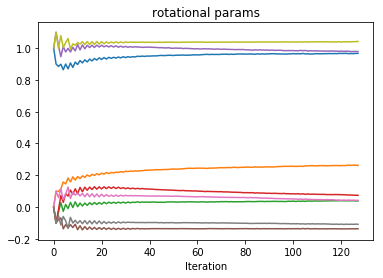

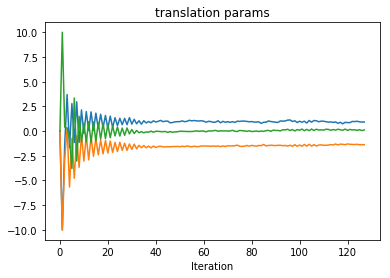

In [101]:
Ts = np.array(aligner.Ts)

plt.plot(Ts[:, [0,1,2,4,5,6,8,9,10]]);
plt.title('rotational params');
plt.xlabel('Iteration');
plt.show();

plt.plot(Ts[:, [3,7,11]]);
plt.title('translation params');
plt.xlabel('Iteration');
plt.show();

Best trial: 0
0.387302192603 0.379912410162
[[  8.78588805e-01   1.90033793e-01  -3.10007020e-03  -1.15445007e+00]
 [  8.02739786e-02   1.00569298e+00  -1.28970009e-01  -3.66576112e+00]
 [  9.31769109e-02  -1.00818680e-01   1.02683096e+00   1.49491915e+00]]


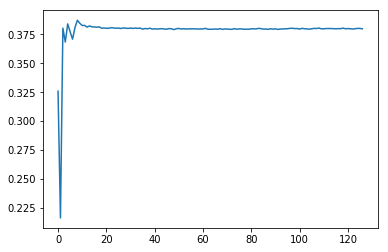

In [102]:
best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]
# best_trial = 1
T = T_all_trials[best_trial]
scores = scores_all_trials[best_trial]
print 'Best trial:', best_trial
print max(scores), scores[-1]

print T.reshape((3,4))
plt.figure();
plt.plot(scores);
plt.show();

In [103]:
# global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# (affine_components_to_vector(-9.77304587,  48.73149657,  -2.80149108,  -0.16628751), 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

# global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# (np.array([1,0,0,130,0,1,0,-70,0,0,1,0]), 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

# global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# (grid_search_T, 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
(T, 
  aligner.centroid_m, aligner.centroid_f,
  aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
  aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

# global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# (np.array([1,0,0,0,0,1,0,0,0,0,1,0]), 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

In [104]:
# Transform moving volume, sided, without surround

structure = 'RMC_L'


In [105]:
label_mapping_m2f

{7: 1, 8: 2, 59: 3, 60: 4, 71: 5, 72: 6}

In [112]:
volume_fixed[1].shape

(164, 113, 193)

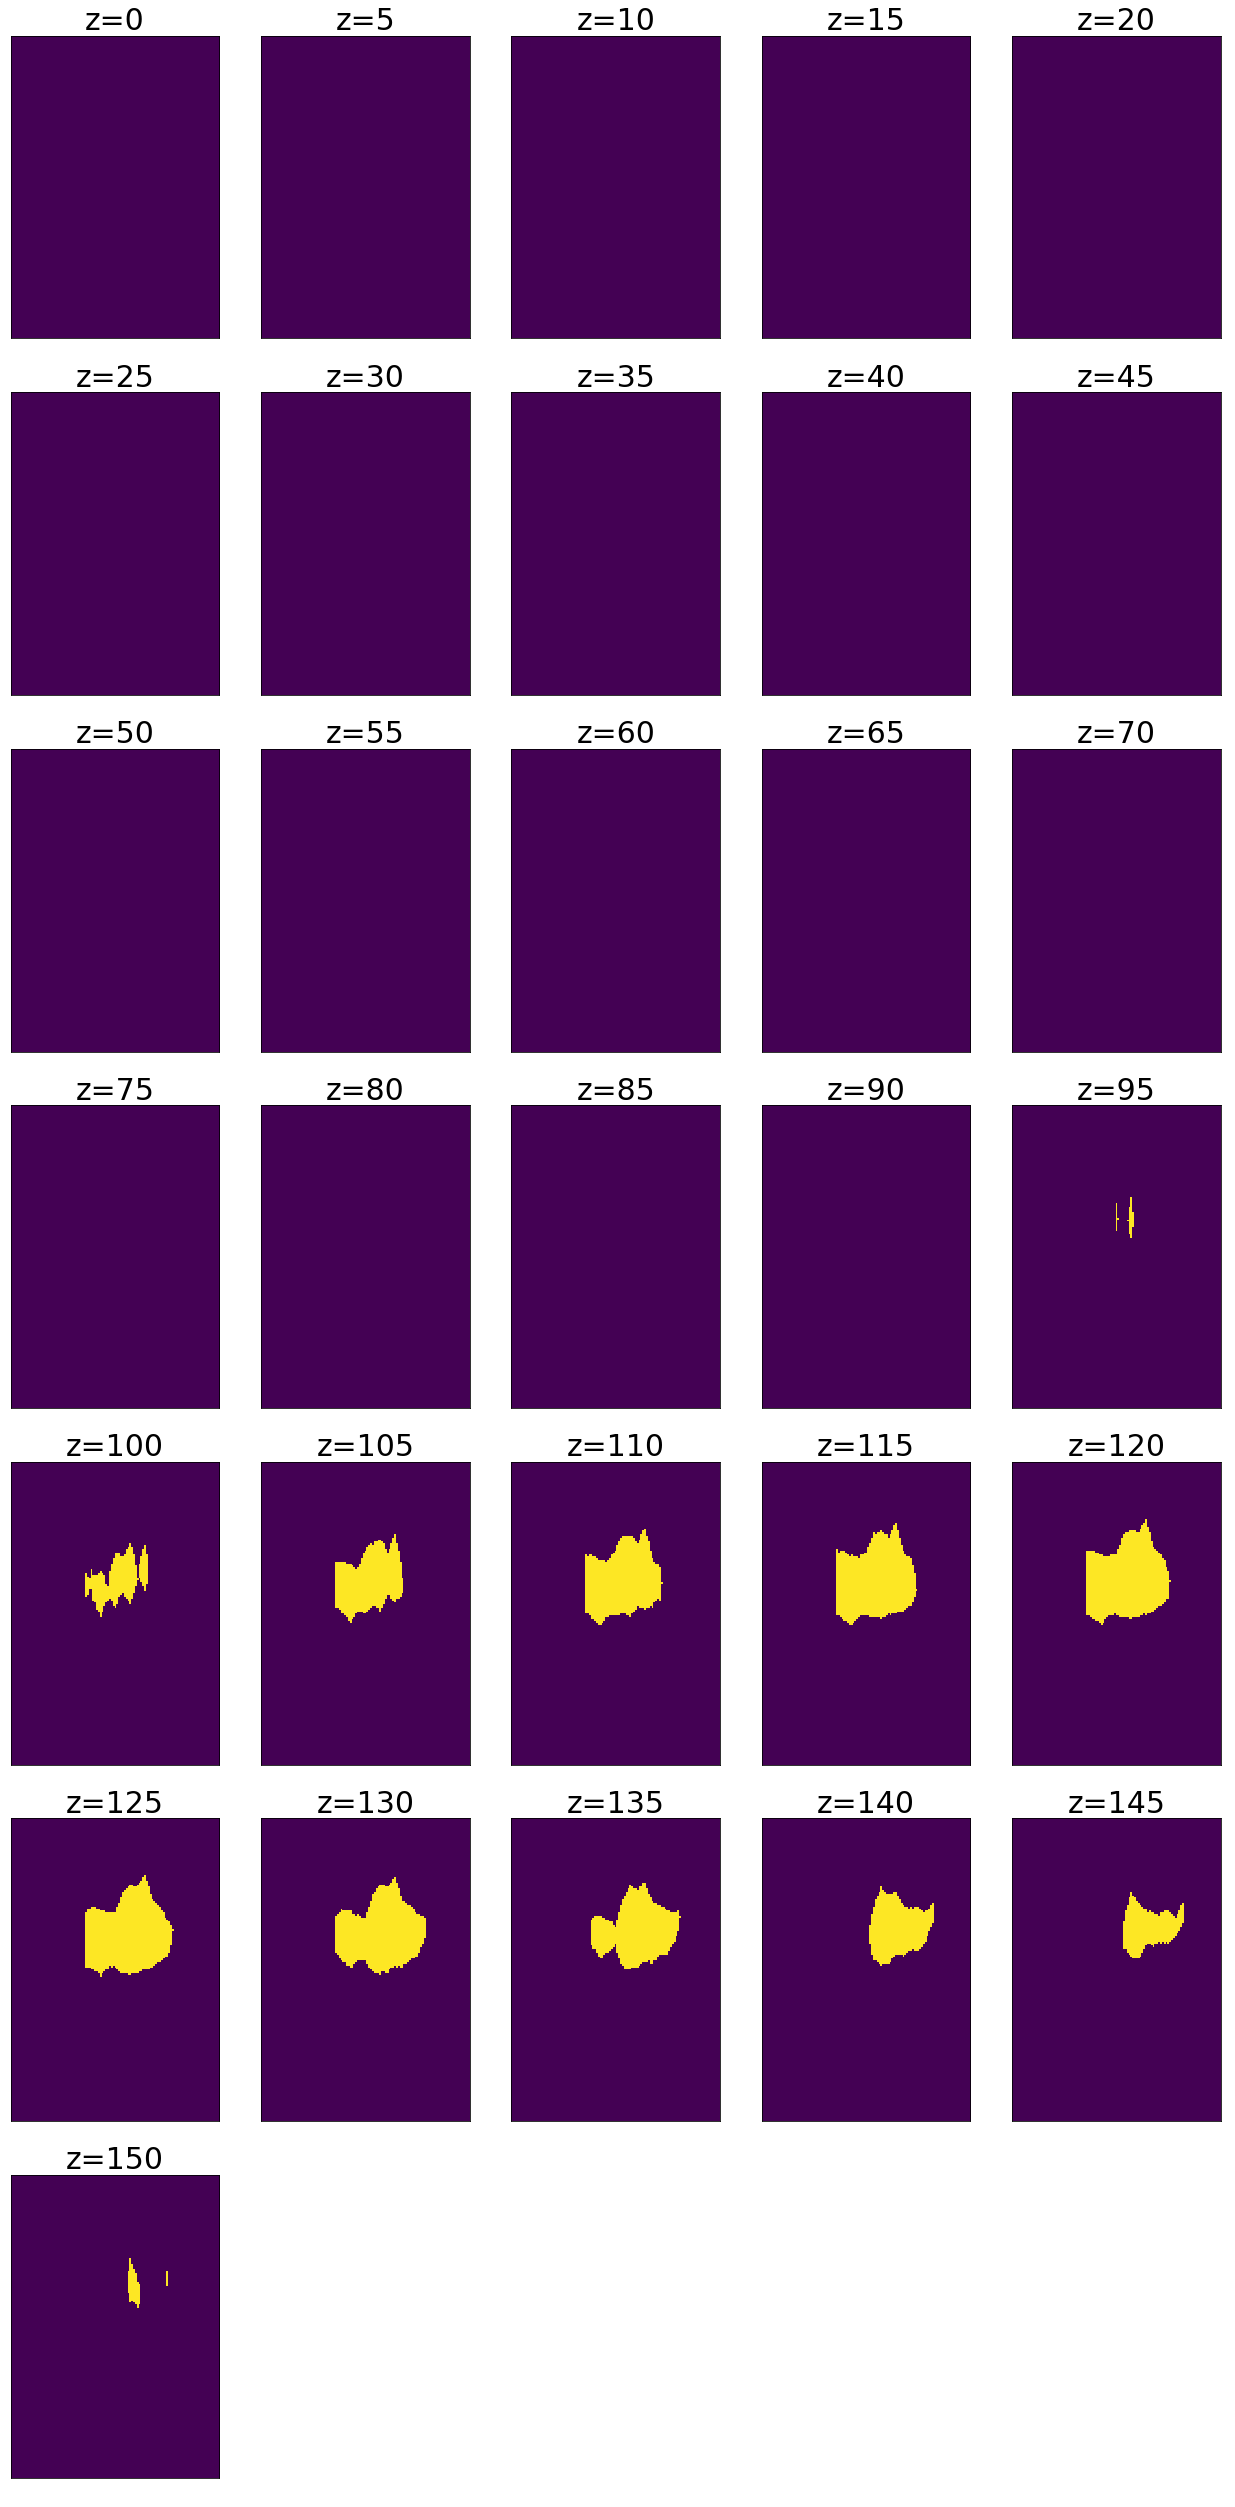

In [107]:
display_volume_sections(volume_fixed[structure_to_label_fixed[structure]], start_level=0)

In [108]:
# vol_m = DataManager.load_original_volume(stack=stack_moving, structure=structure, downscale=32)

vol_m = volume_moving[structure_to_label_moving[structure]]

volume_m_alignedTo_f, volume_m_alignedTo_f_bbox = \
transform_volume_v2(vol=vol_m, tf_params=global_params, centroid_m=centroid_m, centroid_f=centroid_f)

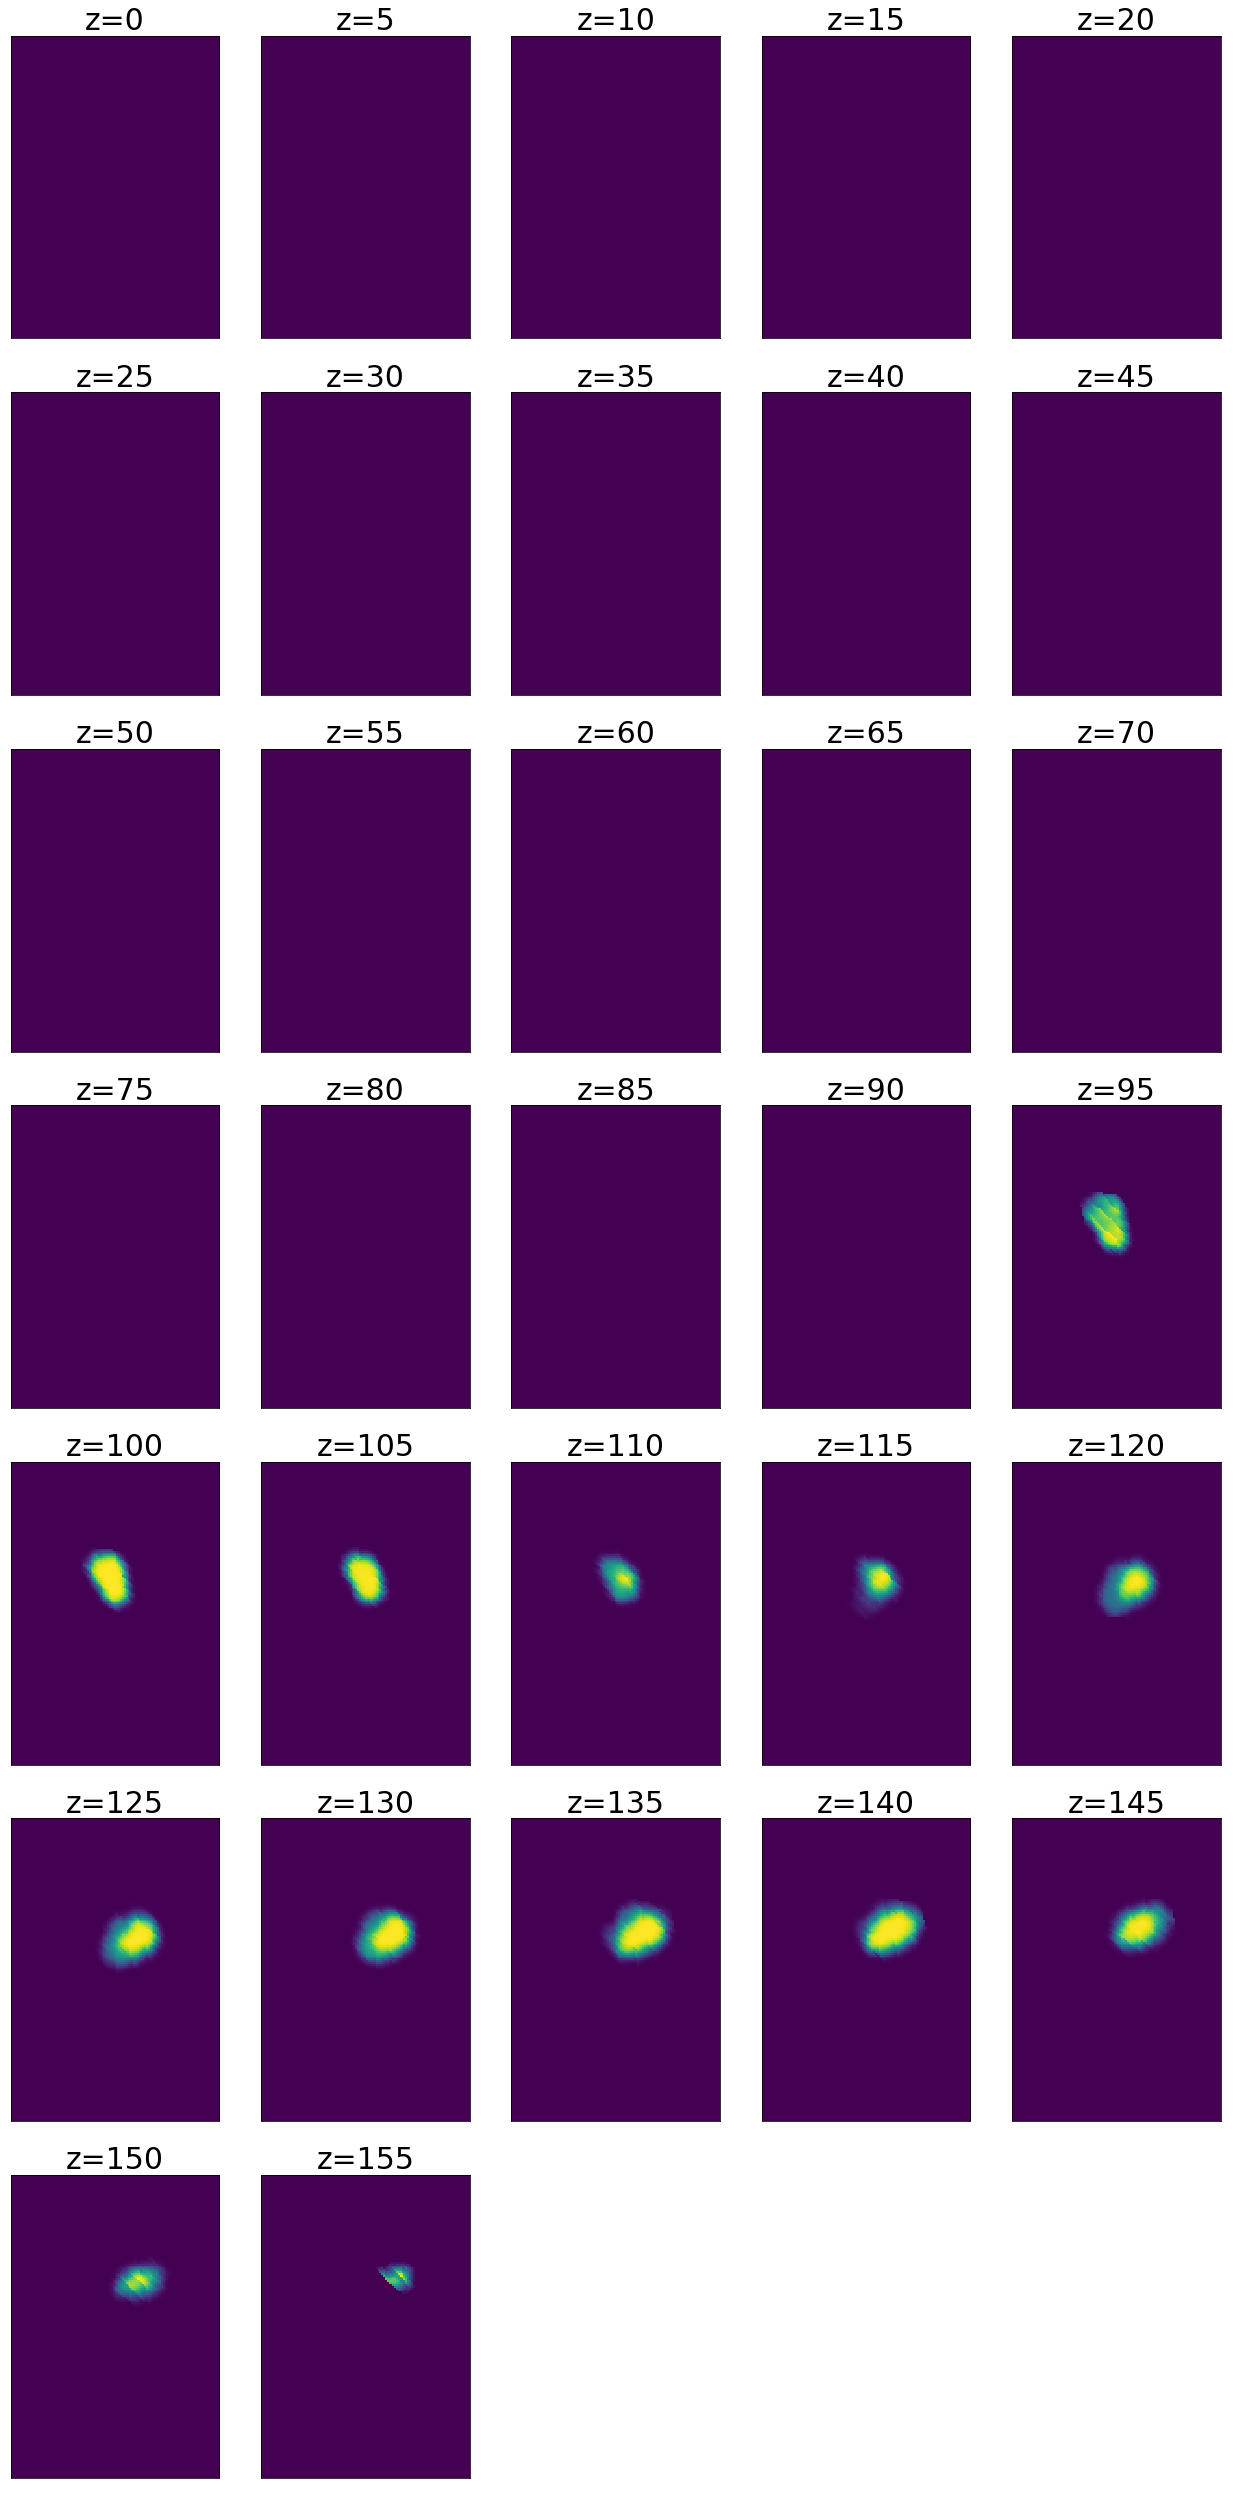

In [113]:
display_volume_sections(crop_and_pad_volume(volume_m_alignedTo_f, in_bbox=volume_m_alignedTo_f_bbox,
                                           out_bbox=(0, xdim_f-1, 0, ydim_f-1, 0, zdim_f-1)), 
                        start_level=0)

# Local

In [7]:
warp_setting = 17

In [8]:
warp_properties = registration_settings.loc[warp_setting]
print warp_properties

upstream_warp_setting = warp_properties['upstream_warp_id']
if upstream_warp_setting == 'None':
    upstream_warp_setting = None
else:
    upstream_warp_setting = int(upstream_warp_setting)
    
transform_type = warp_properties['transform_type']
terminate_thresh = warp_properties['terminate_thresh']
grad_computation_sample_number = warp_properties['grad_computation_sample_number']
grid_search_sample_number = warp_properties['grid_search_sample_number']
std_tx_um = warp_properties['std_tx_um']
std_ty_um = warp_properties['std_ty_um']
std_tz_um = warp_properties['std_tz_um']
std_tx = std_tx_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_ty = std_ty_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_tz = std_tz_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_theta_xy = np.deg2rad(warp_properties['std_theta_xy_degree'])

try:
    surround_weight = float(warp_properties['surround_weight'])
    include_surround = surround_weight != 0 and not np.isnan(surround_weight)
except:
    surround_weight = str(warp_properties['surround_weight'])
    include_surround = True

reg_weight = warp_properties['regularization_weight']
if np.isnan(reg_weight):
    reg_weights = np.zeros((3,))
else:
    reg_weights = np.ones((3,))*reg_weight

print
print 'std', std_tx, std_ty, std_tz, std_theta_xy
print 'surround', surround_weight
print 'regularization', reg_weights

upstream_warp_id                         16
transform_type                        rigid
terminate_thresh                      1e-06
grad_computation_sample_number       100000
grid_search_sample_number             10000
std_tx_um                               200
std_ty_um                               200
std_tz_um                               200
std_theta_xy_degree                      30
surround_weight                     inverse
regularization_weight                     0
comment                           local reg
Name: 17, dtype: object

std 13.5869565217 13.5869565217 13.5869565217 0.523598775598
surround inverse
regularization [ 0.  0.  0.]


In [9]:
MAX_ITER_NUM = 10000
HISTORY_LEN = 200
MAX_GRID_SEARCH_ITER_NUM = 30

In [10]:
lr1 = 10
lr2 = 0.1

In [11]:
volume_fixed, structure_to_label_fixed, label_to_structure_fixed = \
DataManager.load_original_volume_all_known_structures(stack=stack_fixed, sided=True, 
                                                      volume_type='annotationAsScore',
                                                     include_surround=include_surround)

print volume_fixed[1].shape

Prior structure/index map not found. Generating a new one.


rm -rf "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_outerContour.bp" && mkdir -p "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_outerContour.bp" "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_outerContour.bp"


File does not exist: /shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_outerContour.bp
Score volume for outerContour does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_outerContour.bp'


rm -rf "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_outerContour_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_outerContour_surround_200.bp" "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_outerContour_surround_200.bp"


File does not exist: /shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_outerContour_surround_200.bp
Score volume for outerContour_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_outerContour_surround_200.bp'


rm -rf "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_sp5.bp" && mkdir -p "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_sp5.bp" "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_sp5.bp"


File does not exist: /shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_sp5.bp
Score volume for sp5 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_sp5.bp'


rm -rf "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_sp5_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_sp5_surround_200.bp" "/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_sp5_surround_200.bp"


File does not exist: /shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_sp5_surround_200.bp
Score volume for sp5_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_sp5_surround_200.bp'
Volume shape: (356, 427, 375)
Prior structure/index map not found. Generating a new one.


(356, 427, 375)
rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_L.bp
Score volume for 10N_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_L_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_L_surround_200.bp
Score volume for 10N_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_R.bp
Score volume for 10N_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_R_surround_200.bp
Score volume for 10N_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_10N_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_12N.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_12N.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_12N.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_12N.bp
Score volume for 12N does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_12N.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_12N_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_12N_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_12N_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_12N_surround_200.bp
Score volume for 12N_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_12N_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_3N_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_3N_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_3N_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_3N_R.bp
Score volume for 3N_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_3N_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_3N_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_3N_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_3N_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_3N_R_surround_200.bp
Score volume for 3N_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_3N_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_L.bp
Score volume for 4N_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_L_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_L_surround_200.bp
Score volume for 4N_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_R.bp
Score volume for 4N_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_R_surround_200.bp
Score volume for 4N_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_4N_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_L.bp
Score volume for 5N_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_L_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_L_surround_200.bp
Score volume for 5N_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_R.bp
Score volume for 5N_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_R_surround_200.bp
Score volume for 5N_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_5N_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_L.bp
Score volume for 6N_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_L_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_L_surround_200.bp
Score volume for 6N_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_R.bp
Score volume for 6N_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_R_surround_200.bp
Score volume for 6N_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_6N_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_L.bp
Score volume for 7N_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_L_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_L_surround_200.bp
Score volume for 7N_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_R.bp
Score volume for 7N_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_R_surround_200.bp
Score volume for 7N_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7N_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_L.bp
Score volume for 7n_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_L_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_L_surround_200.bp
Score volume for 7n_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_R.bp
Score volume for 7n_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_R_surround_200.bp
Score volume for 7n_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_7n_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_AP.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_AP.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_AP.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_AP.bp
Score volume for AP does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_AP.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_AP_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_AP_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_AP_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_AP_surround_200.bp
Score volume for AP_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_AP_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_L.bp
Score volume for Amb_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_L_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_L_surround_200.bp
Score volume for Amb_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_R.bp
Score volume for Amb_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_R_surround_200.bp
Score volume for Amb_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Amb_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_L.bp
Score volume for DC_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_L_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_L_surround_200.bp
Score volume for DC_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_R.bp
Score volume for DC_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_R_surround_200.bp
Score volume for DC_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_DC_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_IC.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_IC.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_IC.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_IC.bp
Score volume for IC does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_IC.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_IC_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_IC_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_IC_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_IC_surround_200.bp
Score volume for IC_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_IC_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_L.bp
Score volume for LC_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_L_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_L_surround_200.bp
Score volume for LC_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_R.bp
Score volume for LC_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_R_surround_200.bp
Score volume for LC_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LC_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_L.bp
Score volume for LRt_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_L_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_L_surround_200.bp
Score volume for LRt_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_R.bp
Score volume for LRt_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_R_surround_200.bp
Score volume for LRt_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_LRt_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_L.bp
Score volume for PBG_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_L_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_L_surround_200.bp
Score volume for PBG_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_R.bp
Score volume for PBG_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_R_surround_200.bp
Score volume for PBG_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_PBG_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_L.bp
Score volume for Pn_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_L_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_L_surround_200.bp
Score volume for Pn_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_R.bp
Score volume for Pn_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_R_surround_200.bp
Score volume for Pn_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Pn_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RMC_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RMC_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RMC_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RMC_R.bp
Score volume for RMC_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RMC_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RMC_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RMC_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RMC_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RMC_R_surround_200.bp
Score volume for RMC_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RMC_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RtTg.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RtTg.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RtTg.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RtTg.bp
Score volume for RtTg does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RtTg.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RtTg_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RtTg_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RtTg_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RtTg_surround_200.bp
Score volume for RtTg_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_RtTg_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SC.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SC.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SC.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SC.bp
Score volume for SC does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SC.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SC_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SC_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SC_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SC_surround_200.bp
Score volume for SC_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SC_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_L.bp
Score volume for SNC_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_L_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_L_surround_200.bp
Score volume for SNC_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_R.bp
Score volume for SNC_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_R_surround_200.bp
Score volume for SNC_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNC_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNR_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNR_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNR_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNR_R.bp
Score volume for SNR_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNR_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNR_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNR_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNR_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNR_R_surround_200.bp
Score volume for SNR_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNR_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_L.bp
Score volume for Sp5C_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_L_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_L_surround_200.bp
Score volume for Sp5C_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_R.bp
Score volume for Sp5C_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_R_surround_200.bp
Score volume for Sp5C_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5C_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_L.bp
Score volume for Sp5I_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_L_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_L_surround_200.bp
Score volume for Sp5I_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_R.bp
Score volume for Sp5I_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_R_surround_200.bp
Score volume for Sp5I_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5I_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_L.bp
Score volume for Sp5O_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_L_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_L_surround_200.bp
Score volume for Sp5O_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_R.bp
Score volume for Sp5O_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_R_surround_200.bp
Score volume for Sp5O_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Sp5O_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_L.bp
Score volume for Tz_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_L_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_L_surround_200.bp
Score volume for Tz_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_R.bp
Score volume for Tz_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_R_surround_200.bp
Score volume for Tz_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_Tz_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_L.bp
Score volume for VCA_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_L_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_L_surround_200.bp
Score volume for VCA_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_R.bp
Score volume for VCA_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_R_surround_200.bp
Score volume for VCA_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCA_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_L.bp
Score volume for VCP_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_L_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_L_surround_200.bp
Score volume for VCP_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_R.bp
Score volume for VCP_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_R_surround_200.bp
Score volume for VCP_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VCP_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_L.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_L.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_L.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_L.bp
Score volume for VLL_L does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_L.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_L_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_L_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_L_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_L_surround_200.bp
Score volume for VLL_L_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_L_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_R.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_R.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_R.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_R.bp
Score volume for VLL_R does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_R.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_R_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_R_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_R_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_R_surround_200.bp
Score volume for VLL_R_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_VLL_R_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_outerContour.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_outerContour.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_outerContour.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_outerContour.bp
Score volume for outerContour does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_outerContour.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_outerContour_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_outerContour_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_outerContour_surround_200.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_outerContour_surround_200.bp
Score volume for outerContour_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_outerContour_surround_200.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_sp5.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_sp5.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_sp5.bp"


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_sp5.bp
Score volume for sp5 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_sp5.bp'


rm -rf "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_sp5_surround_200.bp" && mkdir -p "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_sp5_surround_200.bp" "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_sp5_surround_200.bp"
(164, 113, 193)


File does not exist: /shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_sp5_surround_200.bp
Score volume for sp5_surround_200 does not exist: [Errno 2] No such file or directory: '/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_sp5_surround_200.bp'
Volume shape: (164, 113, 193)


In [13]:
structure = 'SNR_L'

In [14]:
include_surround = False

In [15]:
from registration_utilities import *

In [16]:
if include_surround:
    volume_moving, structure_to_label_moving, label_to_structure_moving = DataManager.load_original_volume_all_known_structures(stack=stack_moving, 
                                structures=[structure, convert_to_surround_name(structure, margin='200')])
else:
    volume_moving, structure_to_label_moving, label_to_structure_moving = DataManager.load_original_volume_all_known_structures(stack=stack_moving, 
                                                                 structures=[structure])

# structure_to_label_moving = {s: l+1 for l, s in enumerate(sorted(volume_moving.keys()))}
# label_to_structure_moving = {l+1: s for l, s in enumerate(sorted(volume_moving.keys()))}
# volume_moving = {structure_to_label_moving[s]: v for s, v in volume_moving.items()}

label_mapping_m2f = {label_m: structure_to_label_fixed[name_m] 
                     for label_m, name_m in label_to_structure_moving.iteritems()}

if surround_weight == 'inverse':
#             if 'volume_moving_structure_sizes' not in locals():
    volume_moving_structure_sizes = {l: np.count_nonzero(vol > 0) for l, vol in volume_moving.iteritems()}
    label_weights_m = {label_m: -volume_moving_structure_sizes[structure_to_label_moving[convert_to_nonsurround_name(name_m)]]
                       /float(volume_moving_structure_sizes[label_m])
                       if is_surround_label(name_m) else 1. \
                       for label_m, name_m in label_to_structure_moving.iteritems()}
elif isinstance(surround_weight, int) or isinstance(surround_weight, float):
    label_weights_m = {label_m: surround_weight if is_surround_label(name_m) else 1. \
                       for label_m, name_m in label_to_structure_moving.iteritems()}
else:
    sys.stderr.write("surround_weight %s is not recognized. Using the default.\n" % surround_weight)

aligner = Aligner4(volume_fixed, volume_moving, 
                   labelIndexMap_m2f=label_mapping_m2f)

aligner.set_centroid(centroid_m='structure_centroid', centroid_f='structure_centroid', 
                     indices_m=[structure_to_label_moving[structure]])

aligner.set_regularization_weights(reg_weights)
aligner.set_label_weights(label_weights_m)

Prior structure/index map not found. Generating a new one.
Volume shape: (356, 427, 375)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
centroid_m: [  50.43135167  207.82499502   91.38163608], centroid_f: [ 55.08075023  98.82599761  61.5547493 ]


In [17]:
# grid_search_T, grid_search_score = aligner.do_grid_search(grid_search_iteration_number=MAX_GRID_SEARCH_ITER_NUM, 
#                grid_search_sample_number=8,
#               std_tx=std_tx, std_ty=std_ty, std_tz=std_tz, std_theta_xy=0,
#                grid_search_eta=3., stop_radius_voxel=3)

In [18]:
gradient_filepath_map_f = \
{ind_f: DataManager.get_volume_gradient_filepath_template(\
                                                          stack=stack_fixed, 
                                                          structure=label_to_structure_fixed[ind_f],
                                                         volume_type='annotationAsScore')
 for ind_m, ind_f in label_mapping_m2f.iteritems()}

In [19]:
aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f) # 120s = 2 mins

indices_f: set([5])
load gradient 5: 0.076896 seconds
overall: 0.076971 seconds


In [31]:
trial_num = 1

T_all_trials = []
scores_all_trials = []
traj_all_trials = []

for trial_idx in range(trial_num):

    T, scores = aligner.optimize(tf_type=transform_type, 
                                 max_iter_num=MAX_ITER_NUM, 
                                 history_len=HISTORY_LEN, 
#                                  grad_computation_sample_number=int(grad_computation_sample_number),
                                 lr1=1, lr2=1e-2, 
                                 terminate_thresh_trans=0.5, terminate_thresh_rot=0.001)
#                                  init_T=grid_search_T)

#         print T.reshape((3,4))
#         plt.figure();
#         plt.plot(scores);
#         plt.show();
#         print max(scores), scores[-1]

    T_all_trials.append(T)
    scores_all_trials.append(scores)
    traj_all_trials.append(np.array(aligner.Ts))


iteration 0
sample: 0.00 s
0.178690, [    42.40271423   -169.79392283     81.7927727   13689.91388899
   4807.87826042 -18861.4598246 ]
step: 0.13 seconds
current score: 0.178690
new_T: [ 0.99993333 -1.00996642  0.98996692]
det: 1.00

iteration 1
sample: 0.00 s
0.178930, [    65.70476406     23.67221615    -72.22119747 -15074.57298333
  15507.1733415  -11215.93791158]
step: 0.12 seconds
current score: 0.178930
new_T: [ 1.8373266  -0.87648806  0.32357855]
det: 1.00

iteration 2
sample: 0.00 s
0.178697, [  -62.28048792  -119.47481717    26.38494421  6191.12034023  1197.65713116
 -5762.83089194]
step: 0.12 seconds
current score: 0.178697
new_T: [ 1.21369427 -1.44779488  0.55801268]
det: 1.00

iteration 3
sample: 0.00 s
0.178775, [    53.25880987     22.21777862    -61.61516812 -12802.28979205
  13483.44870004  -9350.77404777]
step: 0.12 seconds
current score: 0.178775
new_T: [ 1.68254126 -1.3442029   0.07509226]
det: 1.00

iteration 4
sample: 0.00 s
0.178711, [  -24.00706102   -79.764819

0.178504, [  2.95607496e+00  -4.16487824e+00   7.12719162e-02   3.46441649e+02
   5.26939580e+03  -1.78798888e+03]
step: 0.12 seconds
current score: 0.178504
new_T: [ 1.99504347 -2.73019957 -0.55120477]
det: 1.00

iteration 36
sample: 0.00 s
0.178473, [  4.13534198e+00  -2.02498875e+00  -8.89742636e-01   1.49859038e+02
   5.51536285e+03  -1.78011086e+03]
step: 0.12 seconds
current score: 0.178473
new_T: [ 2.02964958 -2.73887034 -0.55759347]
det: 1.00

iteration 37
sample: 0.00 s
0.178485, [ -1.87483026e-01  -5.54621954e+00   1.66974979e+00   7.42305607e+02
   4.96237392e+03  -1.56299199e+03]
step: 0.12 seconds
current score: 0.178485
new_T: [ 2.02808176 -2.76258692 -0.54565179]
det: 1.00

iteration 38
sample: 0.00 s
0.178506, [ -1.13377723e+00  -1.27932960e+00  -4.09645846e-01   2.76131629e+02
   4.99613124e+03  -1.22925894e+03]
step: 0.12 seconds
current score: 0.178506
new_T: [ 2.01858962 -2.76805521 -0.5485765 ]
det: 1.00

iteration 39
sample: 0.00 s
0.178492, [ -1.38177520e+00  -8.

0.178590, [ -8.26235865e-01   5.19024127e-01  -3.52557425e-01   6.21182250e+02
   4.09945289e+03  -7.24928995e+02]
step: 0.12 seconds
current score: 0.178590
new_T: [ 1.82143054 -2.81147752 -0.58796118]
det: 1.00

iteration 70
sample: 0.00 s
0.178577, [  2.56788043e+00  -6.75893180e-01   2.01935185e+00   9.58987808e+02
   4.25090570e+03  -1.13068799e+03]
step: 0.12 seconds
current score: 0.178577
new_T: [ 1.84281432 -2.81437001 -0.57354479]
det: 1.00

iteration 71
sample: 0.00 s
0.178594, [ -1.84516240e+00   2.98564165e+00  -2.81586017e+00   1.97216555e+02
   4.28132991e+03  -6.40657609e+02]
step: 0.12 seconds
current score: 0.178594
new_T: [ 1.82744729 -2.80161916 -0.59365009]
det: 1.00

iteration 72
sample: 0.00 s
0.178591, [ -2.92686433e+00  -1.56197738e+00  -1.92729767e+00   6.15275162e+02
   4.07141634e+03  -7.12403047e+02]
step: 0.12 seconds
current score: 0.178591
new_T: [ 1.80308438 -2.80828442 -0.60740518]
det: 1.00

iteration 73
sample: 0.00 s
0.178611, [  6.43806179e-01   4.

0.178685, [ -5.59990921e+00  -2.38340231e+00   6.38164166e+00   1.52698464e+03
   3.00761510e+03  -6.28417323e+02]
step: 0.12 seconds
current score: 0.178685
new_T: [ 1.64319084 -2.74586973 -0.56456492]
det: 1.00

iteration 104
sample: 0.00 s
0.178705, [ -2.76844706e-01   4.92343946e+00  -5.50192616e+00  -6.36843648e+01
   4.04677024e+03  -7.16225198e+02]
step: 0.12 seconds
current score: 0.178705
new_T: [ 1.64091992 -2.72492344 -0.60356698]
det: 1.00

iteration 105
sample: 0.00 s
0.178702, [ -6.65843563e+00  -1.06181153e-01   5.42918134e+00   1.25972087e+03
   2.95915821e+03  -3.01926336e+02]
step: 0.12 seconds
current score: 0.178702
new_T: [ 1.5866946  -2.7253811  -0.56509345]
det: 1.00

iteration 106
sample: 0.00 s
0.178731, [  1.67816497e+00   8.14880484e+00  -4.64669837e+00  -2.57692173e+02
   4.06206173e+03  -7.86541811e+02]
step: 0.12 seconds
current score: 0.178731
new_T: [ 1.6003544  -2.69073644 -0.59799808]
det: 1.00

iteration 107
sample: 0.00 s
0.178744, [  4.42813821e-01 

0.178712, [ -4.49653016e-01  -2.79288484e+00   1.54727241e+00   1.04065424e+03
   2.97118343e+03  -1.03646618e+03]
step: 0.13 seconds
current score: 0.178712
new_T: [ 1.7274631  -2.77508768 -0.5901805 ]
det: 1.00

iteration 138
sample: 0.00 s
0.178706, [  1.88269323e+00   2.00679708e-01   1.10118465e+00   7.56664984e+02
   3.02389036e+03  -9.81431817e+02]
step: 0.12 seconds
current score: 0.178706
new_T: [ 1.74213307 -2.7742434  -0.58245755]
det: 1.00

iteration 139
sample: 0.00 s
0.178747, [ -1.68944551e+00   1.16762230e+00   1.62363131e+00   7.04046210e+02
   2.70617576e+03  -6.33515682e+02]
step: 0.12 seconds
current score: 0.178747
new_T: [ 1.72897518 -2.76931283 -0.57106193]
det: 1.00

iteration 140
sample: 0.00 s
0.178758, [ -4.60034639e+00   2.82778310e-01  -1.41949930e+00   4.66791962e+02
   2.84265769e+03  -4.64730875e+02]
step: 0.12 seconds
current score: 0.178758
new_T: [ 1.69315825 -2.76811539 -0.58101202]
det: 1.00

iteration 141
sample: 0.00 s
0.178740, [  1.88163665e+00 

0.178816, [ -1.83991136e+00  -8.89888970e-01  -7.78108761e-02   5.67273702e+02
   2.50470110e+03  -5.01088620e+02]
step: 0.12 seconds
current score: 0.178816
new_T: [ 1.49122725 -2.68124059 -0.61526612]
det: 1.00

iteration 174
sample: 0.00 s
0.178824, [ -3.90894807e+00   1.53803222e+00   1.69362075e+00   5.96429792e+02
   2.22888926e+03  -1.04135884e+02]
step: 0.12 seconds
current score: 0.178824
new_T: [ 1.46187482 -2.67477757 -0.60344835]
det: 1.00

iteration 175
sample: 0.00 s
0.178846, [  3.44894420e+00   2.89532123e+00  -1.58841927e+00   8.47475234e+01
   2.88445837e+03  -8.01532580e+02]
step: 0.12 seconds
current score: 0.178846
new_T: [ 1.48776519 -2.66261349 -0.61453171]
det: 1.00

iteration 176
sample: 0.00 s
0.178804, [ -4.15956993e-01  -4.61334213e-01   2.68327649e+00   8.10752460e+02
   2.48028759e+03  -6.10723961e+02]
step: 0.12 seconds
current score: 0.178804
new_T: [ 1.48464633 -2.66455443 -0.59582217]
det: 1.00

iteration 177
sample: 0.00 s
0.178813, [ -1.39422160e+00 

0.178908, [ -5.32566927e+00   9.10651181e-01   1.41470245e+00   7.31369808e+02
   1.91976163e+03   1.86194622e+01]
step: 0.12 seconds
current score: 0.178908
new_T: [ 1.55073765 -2.73835689 -0.6381289 ]
det: 1.00

iteration 210
sample: 0.00 s
0.178898, [   -7.20248899     3.25375889     2.56518434   607.31534827  1838.94506801
   287.46390622]
step: 0.12 seconds
current score: 0.178898
new_T: [ 1.49871438 -2.7247754  -0.62049468]
det: 1.00

iteration 211
sample: 0.00 s
0.178902, [    8.24341107     4.20861355    -3.94219976   -85.50178092  3227.72286561
 -1312.64584754]
step: 0.12 seconds
current score: 0.178902
new_T: [ 1.55814954 -2.70721774 -0.64758698]
det: 1.00

iteration 212
sample: 0.00 s
0.178888, [   -8.42083838    -2.51931334     5.44568066  1294.58265934  1745.36671524
   -93.82731186]
step: 0.12 seconds
current score: 0.178888
new_T: [ 1.4975481  -2.71774165 -0.61020395]
det: 1.00

iteration 213
sample: 0.00 s
0.178955, [  5.33060218e+00   4.47507917e+00  -1.60219734e-01   

0.179012, [ -3.46006072e+00  -1.59447202e+00   7.67607209e-01   6.16777108e+02
   1.61211711e+03  -1.26871923e+02]
step: 0.12 seconds
current score: 0.179012
new_T: [ 1.44943712 -2.71704185 -0.66760145]
det: 1.00

iteration 246
sample: 0.00 s
0.179048, [  2.77417071e+00   3.38994995e+00  -1.54674009e+00   1.50821155e+02
   2.13253607e+03  -3.72458788e+02]
step: 0.12 seconds
current score: 0.179048
new_T: [ 1.46921506 -2.70292674 -0.67816077]
det: 1.00

iteration 247
sample: 0.00 s
0.179013, [ -3.70045538e-03   3.57671963e-01   2.68861980e+00   8.11084392e+02
   1.65400109e+03  -2.29398060e+02]
step: 0.12 seconds
current score: 0.179013
new_T: [ 1.46919116 -2.70143982 -0.65981418]
det: 1.00

iteration 248
sample: 0.00 s
0.179048, [  2.17898951e-01   1.16992952e+00  -2.15709992e+00   2.29684947e+02
   1.96180059e+03  -2.84289351e+02]
step: 0.12 seconds
current score: 0.179048
new_T: [ 1.4707426  -2.69656774 -0.67453209]
det: 1.00

iteration 249
sample: 0.00 s
0.179024, [ -4.87505676e-01 

0.179015, [  1.02751319e+00   8.73983861e+00  -2.45957804e+00  -4.43275189e+02
   1.89055771e+03   5.87805006e+01]
step: 0.12 seconds
current score: 0.179015
new_T: [ 1.36045268 -2.70339951 -0.78680883]
det: 1.00

iteration 282
sample: 0.00 s
0.179055, [   -5.03558577    -1.29634892     6.35374089  1184.10519266   883.62276609
   132.59271564]
step: 0.12 seconds
current score: 0.179055
new_T: [ 1.3253026  -2.70875089 -0.74438206]
det: 1.00

iteration 283
sample: 0.00 s
0.178967, [    3.75472555     4.96360701    -2.43238496  -246.3169601   2201.54635972
  -524.25394535]
step: 0.12 seconds
current score: 0.178967
new_T: [ 1.35150388 -2.6883016  -0.76062685]
det: 1.00

iteration 284
sample: 0.00 s
0.178982, [ -5.90634906e+00  -9.75378585e-02   5.49401590e+00   8.68127673e+02
   9.20921702e+02   2.30963538e+02]
step: 0.12 seconds
current score: 0.178982
new_T: [ 1.3103238  -2.68871003 -0.72396864]
det: 1.00

iteration 285
sample: 0.00 s
0.178950, [  4.78759263e+00   8.02714554e+00  -2.048

0.179147, [ -1.48876993e+00   8.08791044e-01  -2.44236815e+00  -1.93828370e+02
   1.52158364e+03  -1.82468013e+02]
step: 0.12 seconds
current score: 0.179147
new_T: [ 1.27892627 -2.64830275 -0.68620218]
det: 1.00

iteration 318
sample: 0.00 s
0.179148, [  2.64402401e+00  -2.39910849e+00  -7.78714931e-01   3.76280614e+02
   1.51015424e+03  -6.79019788e+02]
step: 0.13 seconds
current score: 0.179148
new_T: [ 1.29723504 -2.65815955 -0.69137309]
det: 1.00

iteration 319
sample: 0.00 s
0.179154, [  3.15843147e+00  -2.70937719e+00  -1.31504371e+00   3.10868279e+02
   1.65779837e+03  -7.70858851e+02]
step: 0.12 seconds
current score: 0.179154
new_T: [ 1.31910015 -2.66929074 -0.70010379]
det: 1.00

iteration 320
sample: 0.00 s
0.179121, [ -1.31174819e+00  -1.69111425e+00  -1.96992919e-01   4.41046918e+02
   1.35890492e+03  -3.17413450e+02]
step: 0.12 seconds
current score: 0.179121
new_T: [ 1.31001814 -2.67623656 -0.70141067]
det: 1.00

iteration 321
sample: 0.00 s
0.179123, [  1.92958539e+00 

0.179123, [ -2.12895367e+00   1.69303584e+00   7.23741263e-01   1.10691003e+02
   8.55278511e+02   2.68785961e+02]
step: 0.12 seconds
current score: 0.179123
new_T: [ 1.30379626 -2.69932324 -0.74093135]
det: 1.00

iteration 354
sample: 0.00 s
0.179151, [ -6.01831295e+00   1.84917714e+00  -1.94633161e-02   1.30472038e+02
   8.22621345e+02   4.69857748e+02]
step: 0.12 seconds
current score: 0.179151
new_T: [ 1.26260199 -2.69175753 -0.74105713]
det: 1.00

iteration 355
sample: 0.00 s
0.179140, [ -2.86929225e+00   9.92074915e-01  -1.05705368e+00   6.00717473e+01
   1.09244747e+03  -5.69678658e+01]
step: 0.12 seconds
current score: 0.179140
new_T: [ 1.24296568 -2.68769685 -0.74803752]
det: 1.00

iteration 356
sample: 0.00 s
0.179109, [  3.68982211e+00   2.63064395e+00  -7.78222886e-01  -6.56484979e+01
   1.29399128e+03  -2.87558152e+02]
step: 0.12 seconds
current score: 0.179109
new_T: [ 1.26820855 -2.67693167 -0.75318042]
det: 1.00

iteration 357
sample: 0.00 s
0.179127, [ -1.03534311e+00 

0.179112, [ -1.47986407e+00   9.45046046e-01  -3.89357942e-01  -5.36497503e+01
   7.84228088e+02  -1.27950414e+01]
step: 0.12 seconds
current score: 0.179112
new_T: [ 1.14920338 -2.50556393 -0.59615511]
det: 1.00

iteration 390
sample: 0.00 s
0.179095, [  5.18483576e-01  -1.13395493e+00   5.02272965e-01   1.25201770e+02
   8.36989854e+02  -3.16893331e+02]
step: 0.12 seconds
current score: 0.179095
new_T: [ 1.15272972 -2.51019522 -0.59284623]
det: 1.00

iteration 391
sample: 0.00 s
0.179103, [ -3.01653830e-01  -3.27094539e-01  -8.76047621e-01  -1.29816423e+01
   8.28444429e+02  -1.47505228e+02]
step: 0.12 seconds
current score: 0.179103
new_T: [ 1.1506777  -2.51153103 -0.5986178 ]
det: 1.00

iteration 392
sample: 0.00 s
0.179084, [  -1.12880614   -1.40986827   -0.92200853   87.23729826  816.7571564
 -170.44259755]
step: 0.12 seconds
current score: 0.179084
new_T: [ 1.14300012 -2.51728853 -0.60469179]
det: 1.00

iteration 393
sample: 0.00 s
0.179119, [    1.26223194    -1.5346125     -2.

0.179123, [ -1.06527301e+00  -5.38084644e-01  -2.16204020e+00   1.78387740e+02
   1.01006807e+03  -1.95958193e+02]
step: 0.12 seconds
current score: 0.179123
new_T: [ 1.11030391 -2.63885719 -0.799402  ]
det: 1.00

iteration 426
sample: 0.00 s
0.179142, [  3.53547306e+00  -1.02545921e+00  -8.24273792e-01   3.37050779e+02
   1.18196950e+03  -6.13211067e+02]
step: 0.12 seconds
current score: 0.179142
new_T: [ 1.13428348 -2.64303269 -0.80481371]
det: 1.00

iteration 427
sample: 0.00 s
0.179205, [ -6.32605487e+00  -2.52454275e+00  -5.11098774e-01   4.25202479e+02
   5.90793986e+02   1.16059519e+02]
step: 0.12 seconds
current score: 0.179205
new_T: [ 1.09141454 -2.65330759 -0.80816653]
det: 1.00

iteration 428
sample: 0.00 s
0.179163, [   10.91550785     2.09832778    -3.15467706   -99.94379045  1823.65695223
 -1007.39218561]
step: 0.12 seconds
current score: 0.179163
new_T: [ 1.16518107 -2.64477926 -0.82887503]
det: 1.00

iteration 429
sample: 0.00 s
0.179154, [  -12.03018368    -8.69080485

0.179216, [ -1.59261972e-02   4.99669027e-01   1.08477686e+00   1.46855669e+02
   8.45318021e+02  -2.84133477e+02]
step: 0.12 seconds
current score: 0.179216
new_T: [ 1.20225838 -2.63816339 -0.72464124]
det: 1.00

iteration 462
sample: 0.00 s
0.179221, [  4.83635250e-01  -5.39429583e-01  -2.18313013e-01   1.10532498e+02
   8.98578333e+02  -3.79991438e+02]
step: 0.12 seconds
current score: 0.179221
new_T: [ 1.20543523 -2.64033494 -0.72605698]
det: 1.00

iteration 463
sample: 0.00 s
0.179221, [ -1.05142624e+00  -1.83149539e+00   6.04944669e-01   2.45529160e+02
   6.54330462e+02  -2.64025463e+02]
step: 0.12 seconds
current score: 0.179221
new_T: [ 1.19852834 -2.64770707 -0.72213463]
det: 1.00

iteration 464
sample: 0.00 s
0.179219, [  5.76845288e-01   1.40827430e+00  -1.69784788e-02   3.56132224e+01
   8.54168573e+02  -2.51997262e+02]
step: 0.12 seconds
current score: 0.179219
new_T: [ 1.2023178  -2.64203863 -0.72224493]
det: 1.00

iteration 465
sample: 0.00 s
0.179222, [ -1.34981492e-01 

0.179236, [  2.62885569e+00   7.18538829e-01  -1.05370990e+00   3.21791801e+01
   1.06260674e+03  -4.63390894e+02]
step: 0.12 seconds
current score: 0.179236
new_T: [ 1.23530874 -2.7017379  -0.77265167]
det: 1.00

iteration 498
sample: 0.00 s
0.179222, [ -1.62741503e+00  -2.29012762e+00   1.93190008e-01   3.42054335e+02
   7.92765688e+02  -2.55452313e+02]
step: 0.12 seconds
current score: 0.179222
new_T: [ 1.22464307 -2.71094805 -0.77140044]
det: 1.00

iteration 499
sample: 0.00 s
0.179219, [  3.61359912e+00   1.09199915e+00  -2.21212152e+00  -4.01011051e+01
   1.25866324e+03  -5.47080996e+02]
step: 0.12 seconds
current score: 0.179219
new_T: [ 1.24831743 -2.70655824 -0.78572672]
det: 1.00

iteration 500
sample: 0.00 s
0.179184, [  -3.62020787   -5.72066787    3.45575511  841.99701246  473.96166431
 -251.70248796]
step: 0.12 seconds
current score: 0.179184
new_T: [ 1.22460539 -2.72956152 -0.76335772]
det: 1.00

iteration 501
sample: 0.00 s
0.179244, [    3.00942067     4.12285469    -6

0.179224, [   2.99457012    1.72160135   -1.89312291 -211.01964918  993.81046937
 -308.09487109]
step: 0.12 seconds
current score: 0.179224
new_T: [ 1.2124394  -2.6778808  -0.76456124]
det: 1.00

iteration 534
sample: 0.00 s
0.179244, [  -4.1693165    -1.04154385    1.40220929  297.60522705  397.61071164
  182.94964273]
step: 0.12 seconds
current score: 0.179244
new_T: [ 1.18557799 -2.68202012 -0.75564882]
det: 1.00

iteration 535
sample: 0.00 s
0.179225, [   0.90263011    0.90933155   -2.46286744 -228.17098138  885.64144909
 -188.86994681]
step: 0.12 seconds
current score: 0.179225
new_T: [ 1.19139234 -2.67840795 -0.77130028]
det: 1.00

iteration 536
sample: 0.00 s
0.179235, [  -1.61891779   -2.83519223    0.77572181  419.35891837  598.1074238
 -170.68065126]
step: 0.12 seconds
current score: 0.179235
new_T: [ 1.18096278 -2.68967185 -0.76637107]
det: 1.00

iteration 537
sample: 0.00 s
0.179252, [  1.20660682e+00   5.56858811e-01  -3.84958194e+00  -3.65921991e+02
   1.02425530e+03  -2.

0.179250, [ -6.43758129e-02   4.73235090e-01   7.04360708e-01   1.82987254e+02
   6.33328638e+02  -1.52434587e+02]
step: 0.12 seconds
current score: 0.179250
new_T: [ 1.11169514 -2.62733345 -0.72033062]
det: 1.00

iteration 570
sample: 0.00 s
0.179252, [ -1.60021336e+00   1.23558899e+00   4.84078203e-01   1.00445646e+02
   5.54956188e+02   4.55492233e+01]
step: 0.12 seconds
current score: 0.179252
new_T: [ 1.10142866 -2.62243519 -0.71725723]
det: 1.00

iteration 571
sample: 0.00 s
0.179248, [  2.68900175e-01   2.13447082e+00   2.43093985e+00   2.91205787e+02
   5.55296967e+02  -7.50348403e+01]
step: 0.12 seconds
current score: 0.179248
new_T: [ 1.1031546  -2.61397431 -0.70182737]
det: 1.00

iteration 572
sample: 0.00 s
0.179246, [ -6.75588813e-01   2.13859699e+00  -3.61634238e-01   6.44090130e+01
   6.64515640e+02   4.73122614e+01]
step: 0.12 seconds
current score: 0.179246
new_T: [ 1.09882006 -2.60549668 -0.70412241]
det: 1.00

iteration 573
sample: 0.00 s
0.179248, [  -1.40573984   -

0.179239, [  1.41763456e+00  -3.33076897e-01   2.99249131e-02   1.64515133e+02
   7.07088565e+02  -3.19782843e+02]
step: 0.12 seconds
current score: 0.179239
new_T: [ 1.07404931 -2.56966519 -0.67524191]
det: 1.00

iteration 606
sample: 0.00 s
0.179263, [  7.43172381e-01  -1.70227488e+00   3.45892194e-01   2.49756294e+02
   6.50864408e+02  -3.64043968e+02]
step: 0.12 seconds
current score: 0.179263
new_T: [ 1.07879278 -2.57640345 -0.6730502 ]
det: 1.00

iteration 607
sample: 0.00 s
0.179271, [  1.02058889e-01  -1.61664788e+00  -2.16083339e+00   5.31529615e+00
   7.08078611e+02  -2.92022377e+02]
step: 0.12 seconds
current score: 0.179271
new_T: [ 1.07944323 -2.58280233 -0.68674397]
det: 1.00

iteration 608
sample: 0.00 s
0.179259, [ -1.11939718e+00  -9.35110133e-01  -3.66553152e-01   1.36028413e+02
   5.35389126e+02  -1.24022078e+02]
step: 0.12 seconds
current score: 0.179259
new_T: [ 1.07229807 -2.58650339 -0.68906669]
det: 1.00

iteration 609
sample: 0.00 s
0.179263, [  4.24036129e-01 

0.179278, [   1.65722995    2.09320593   -2.00195216 -316.88780379  850.5051705
 -305.52576036]
step: 0.12 seconds
current score: 0.179278
new_T: [ 1.08560786 -2.62637628 -0.74650543]
det: 1.00

iteration 642
sample: 0.00 s
0.179234, [  -1.62027376   -1.27455323    1.91485401  402.36343296  371.32098396
 -133.79169961]
step: 0.12 seconds
current score: 0.179234
new_T: [ 1.07528163 -2.63141638 -0.7343942 ]
det: 1.00

iteration 643
sample: 0.00 s
0.179250, [   3.15835185    1.50023751   -1.31085608 -134.54229439  912.56370912
 -439.55662456]
step: 0.12 seconds
current score: 0.179250
new_T: [ 1.09540645 -2.62548604 -0.74268645]
det: 1.00

iteration 644
sample: 0.00 s
0.179237, [  -2.53199558    1.02533456    0.42410188   15.12705676  405.88360294
   47.59515199]
step: 0.12 seconds
current score: 0.179237
new_T: [ 1.07927473 -2.62143212 -0.74000365]
det: 1.00

iteration 645
sample: 0.00 s
0.179238, [  4.10334320e-01  -1.61176304e-02   4.56032274e-01   1.96254889e+02
   5.22896517e+02  -1.

0.179338, [  -3.94935635    0.46432245   -0.57811007 -119.02199673  141.716753
  408.14850931]
step: 0.12 seconds
current score: 0.179338
new_T: [ 1.12128008 -2.69989551 -0.80368193]
det: 1.00

iteration 678
sample: 0.00 s
0.179350, [  4.74481146e+00   1.09956955e+00   4.10470901e-01  -3.12456430e+01
   6.78753035e+02  -4.25339373e+02]
step: 0.12 seconds
current score: 0.179350
new_T: [ 1.15111144 -2.69556106 -0.8011008 ]
det: 1.00

iteration 679
sample: 0.00 s
0.179353, [  -3.42559246   -3.23695617   -0.53176356  186.76055209  181.17474135
  154.446805  ]
step: 0.12 seconds
current score: 0.179353
new_T: [ 1.12957973 -2.70832568 -0.80444671]
det: 1.00

iteration 680
sample: 0.00 s
0.179334, [   1.16131951    3.73207477   -0.78086297 -318.59009844  513.82044708
   90.83419868]
step: 0.12 seconds
current score: 0.179334
new_T: [ 1.13687876 -2.69361078 -0.80936081]
det: 1.00

iteration 681
sample: 0.00 s
0.179342, [   1.45864326   -0.94186412    1.19893675  135.37165783  354.922236
 -221

0.179339, [    4.54318861     9.33816085    -7.81874388 -1314.70447997  1302.85188729
  -125.0733607 ]
step: 0.12 seconds
current score: 0.179339
new_T: [ 1.12197216 -2.72513573 -0.88807745]
det: 1.00

iteration 714
sample: 0.00 s
0.179276, [   -7.82651153    -7.44981142     5.62794755  1077.89746095  -422.25295463
   338.11329171]
step: 0.12 seconds
current score: 0.179276
new_T: [ 1.0729325  -2.75445515 -0.85283041]
det: 1.00

iteration 715
sample: 0.00 s
0.179343, [    8.5462841      9.23787971    -2.34997684  -877.11869849  1157.47251076
  -395.60978605]
step: 0.13 seconds
current score: 0.179343
new_T: [ 1.12640665 -2.71813781 -0.86755859]
det: 1.00

iteration 716
sample: 0.00 s
0.179301, [  -5.83330549   -3.96875368    3.48264255  657.14099487 -152.79923447
  297.81858751]
step: 0.12 seconds
current score: 0.179301
new_T: [ 1.08993287 -2.73374439 -0.84575288]
det: 1.00

iteration 717
sample: 0.00 s
0.179353, [   3.06916098    1.10148052   -1.88208791 -209.26433759  874.89297695
 

0.179322, [   -5.34032041    -5.50587262     7.81188898  1326.68546215  -358.82267232
   218.2660816 ]
step: 0.12 seconds
current score: 0.179322
new_T: [ 1.09010111 -2.71202688 -0.80820549]
det: 1.00

iteration 750
sample: 0.00 s
0.179304, [    5.89183697     4.66571234    -5.51831238  -725.25386394  1070.99947606
  -334.96440756]
step: 0.12 seconds
current score: 0.179304
new_T: [ 1.12642975 -2.69377181 -0.84248441]
det: 1.00

iteration 751
sample: 0.00 s
0.179332, [   -4.4636974     -5.81379694     4.86484194  1030.14339037  -227.30443176
   157.04476189]
step: 0.12 seconds
current score: 0.179332
new_T: [ 1.09891591 -2.71652523 -0.81228691]
det: 1.00

iteration 752
sample: 0.00 s
0.179293, [   5.99552594    3.39374122   -3.95013067 -497.4255698   962.62585369
 -358.58604974]
step: 0.12 seconds
current score: 0.179293
new_T: [ 1.1358455  -2.70325122 -0.83680611]
det: 1.00

iteration 753
sample: 0.00 s
0.179320, [  -6.26487436   -4.87352808    3.56725291  884.98576334 -239.71925405
 

0.179310, [  9.17550274e-02   2.40871942e+00  -2.31172169e+00  -3.12853113e+02
   4.50108115e+02   2.48241027e+01]
step: 0.12 seconds
current score: 0.179310
new_T: [ 1.11595394 -2.69686957 -0.80193802]
det: 1.00

iteration 786
sample: 0.00 s
0.179286, [  -0.2725957    -0.97759375    2.41276634  268.14192889  144.75531516
 -145.32108087]
step: 0.12 seconds
current score: 0.179286
new_T: [ 1.11428487 -2.70068739 -0.78701024]
det: 1.00

iteration 787
sample: 0.00 s
0.179316, [   1.00390303    2.13938879   -1.55430698 -295.0706159   368.17413305
  -29.31900237]
step: 0.12 seconds
current score: 0.179316
new_T: [ 1.12043159 -2.69233437 -0.79662692]
det: 1.00

iteration 788
sample: 0.00 s
0.179303, [  -1.34424303   -2.63396608    1.63767578  343.58583118  102.10475764
 -126.0324535 ]
step: 0.12 seconds
current score: 0.179303
new_T: [ 1.11220089 -2.70261881 -0.78649599]
det: 1.00

iteration 789
sample: 0.00 s
0.179324, [  -0.85029512    1.19937016   -2.19763688 -297.63645686  284.9741179
  

0.179317, [  -1.20318204    0.35710319    0.75810007  180.35179233   83.89993492
   88.82195432]
step: 0.12 seconds
current score: 0.179317
new_T: [ 1.0692281  -2.66523038 -0.77446177]
det: 1.00

iteration 822
sample: 0.00 s
0.179334, [  1.25511296e+00   2.90913570e-01  -1.10314252e+00   6.51637519e+00
   3.92920428e+02  -1.11083961e+02]
step: 0.12 seconds
current score: 0.179334
new_T: [ 1.07690608 -2.66409498 -0.78127732]
det: 1.00

iteration 823
sample: 0.00 s
0.179316, [  -2.48971482   -0.86859374    1.14149636  312.69276737   12.99099354
  154.84653605]
step: 0.12 seconds
current score: 0.179316
new_T: [ 1.06167707 -2.66748599 -0.77422537]
det: 1.00

iteration 824
sample: 0.00 s
0.179319, [   3.06773672    1.89664212   -0.55533419 -100.62461999  427.82012535
 -132.58091113]
step: 0.12 seconds
current score: 0.179319
new_T: [ 1.08043854 -2.66008353 -0.77765688]
det: 1.00

iteration 825
sample: 0.00 s
0.179328, [  -3.54166582   -2.94264755    1.15417378  414.18217672  -88.23792882
 

0.179339, [  -2.83896234   -0.65512885    2.55912085  318.15039306 -135.14596924
  189.24329307]
step: 0.12 seconds
current score: 0.179339
new_T: [ 1.0566993  -2.66082196 -0.74032357]
det: 1.00

iteration 860
sample: 0.00 s
0.179333, [   2.31480122    3.53107418   -5.22605261 -677.92126772  542.42281813
   67.80141587]
step: 0.12 seconds
current score: 0.179333
new_T: [ 1.07078027 -2.64705351 -0.77251605]
det: 1.00

iteration 861
sample: 0.00 s
0.179359, [ -4.83142499e-01  -1.01849902e+00   4.89245262e+00   4.92050285e+02
  -2.04699285e+02  -1.80533157e+01]
step: 0.12 seconds
current score: 0.179359
new_T: [ 1.06784054 -2.65102798 -0.74239442]
det: 1.00

iteration 862
sample: 0.00 s
0.179327, [   0.1673788     1.58568975   -0.39807385 -109.53767877  101.90715371
  137.00979174]
step: 0.12 seconds
current score: 0.179327
new_T: [ 1.06885867 -2.64484379 -0.74484539]
det: 1.00

iteration 863
sample: 0.00 s
0.179337, [  -2.66073434    0.35974455    1.52098626  152.61285742 -171.19705823
 

0.179347, [  -4.93202684   -2.69026542    4.69540261  601.49798582 -438.08740765
  309.94721291]
step: 0.12 seconds
current score: 0.179347
new_T: [ 1.05050853 -2.65766486 -0.73259152]
det: 1.00

iteration 898
sample: 0.00 s
0.179355, [   2.86333285    2.56348236   -6.78346344 -830.59955036  583.02629352
 -100.47688564]
step: 0.12 seconds
current score: 0.179355
new_T: [ 1.06783121 -2.64769349 -0.77384321]
det: 1.00

iteration 899
sample: 0.00 s
0.179336, [ -5.20067699e-01  -2.39900607e-01   3.73975548e+00   3.72625653e+02
  -1.61591074e+02   8.75916407e+01]
step: 0.12 seconds
current score: 0.179336
new_T: [ 1.06468434 -2.64862847 -0.75110803]
det: 1.00

iteration 900
sample: 0.00 s
0.179339, [  -0.94278527    1.24241495    0.16923664  -79.02243934   34.73751235
  161.58720309]
step: 0.12 seconds
current score: 0.179339
new_T: [ 1.05898011 -2.64379332 -0.75007923]
det: 1.00

iteration 901
sample: 0.00 s
0.179336, [  -0.34732086    1.88856057   -0.72231923 -177.09856855  110.79447661
 

0.179361, [  2.08792362e+00  -2.12785982e-01  -3.24837985e+00  -3.29273819e+02
   3.73654066e+02  -2.44143407e+02]
step: 0.12 seconds
current score: 0.179361
new_T: [ 1.06519035 -2.64202841 -0.76344138]
det: 1.00

iteration 934
sample: 0.00 s
0.179348, [  -2.92263135   -0.6629755     2.13009497  259.51975868 -193.9400467
  265.27584882]
step: 0.12 seconds
current score: 0.179348
new_T: [ 1.04753889 -2.64460854 -0.75056306]
det: 1.00

iteration 935
sample: 0.00 s
0.179353, [   1.35636359   -0.28799809   -2.2714232  -224.74293999  266.35751081
 -177.97992805]
step: 0.12 seconds
current score: 0.179353
new_T: [ 1.05573013 -2.64572951 -0.76429504]
det: 1.00

iteration 936
sample: 0.00 s
0.179363, [  -0.25980832    0.61038033    1.91526765  105.40419039  -47.5623185
   73.71418183]
step: 0.12 seconds
current score: 0.179363
new_T: [ 1.054161   -2.64335536 -0.75271706]
det: 1.00

iteration 937
sample: 0.00 s
0.179358, [   0.43268809    1.12268829   -1.15356845 -232.72222166  159.39335019
   

0.179369, [  -0.36654676    0.37458265   -1.06648629  -57.93295744  153.40737074
   54.37613427]
step: 0.12 seconds
current score: 0.179369
new_T: [ 1.06191873 -2.6533659  -0.77573708]
det: 1.00

iteration 970
sample: 0.00 s
0.179373, [  3.65693882e-01  -2.10239111e-02   4.08611700e-01   1.10394295e+02
   9.12702973e+01   7.94911363e+00]
step: 0.12 seconds
current score: 0.179373
new_T: [ 1.06412437 -2.65344769 -0.7732694 ]
det: 1.00

iteration 971
sample: 0.00 s
0.179371, [  9.85972810e-02  -3.95974608e-01  -7.32696740e-02   3.87903058e+01
   8.74729651e+01  -3.12954391e+01]
step: 0.12 seconds
current score: 0.179371
new_T: [ 1.06471903 -2.65498734 -0.77371191]
det: 1.00

iteration 972
sample: 0.00 s
0.179377, [ -2.14093706e-01  -5.91083467e-02  -7.07631240e-01  -3.32588814e+01
   9.58659506e+01   1.85802068e+01]
step: 0.12 seconds
current score: 0.179377
new_T: [ 1.06342773 -2.6552172  -0.77798539]
det: 1.00

iteration 973
sample: 0.00 s
0.179378, [   0.39902932   -1.3027232     0.64

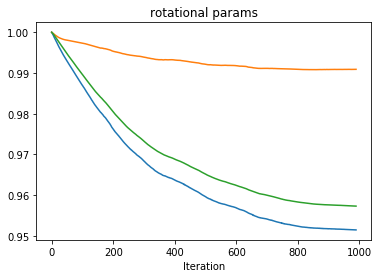

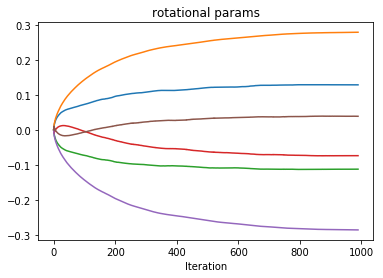

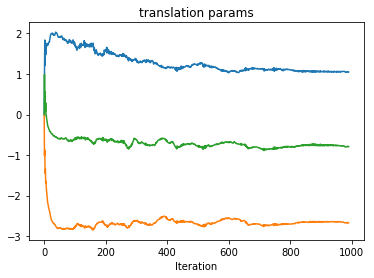

In [32]:
Ts = np.array(aligner.Ts)

plt.plot(Ts[:, [0,5,10]]);
plt.title('rotational params');
plt.xlabel('Iteration');
plt.show();

plt.plot(Ts[:, [1,2,4,6,8,9]]);
plt.title('rotational params');
plt.xlabel('Iteration');
plt.show();

plt.plot(Ts[:, [3,7,11]]);
plt.title('translation params');
plt.xlabel('Iteration');
plt.show();

Best trial: 0
0.179386 0.17936
[[ 0.95156748  0.12900018  0.2790668   1.06509228]
 [-0.11265674  0.99088194 -0.07390151 -2.64316692]
 [-0.28605556  0.03888352  0.95742378 -0.77212299]]


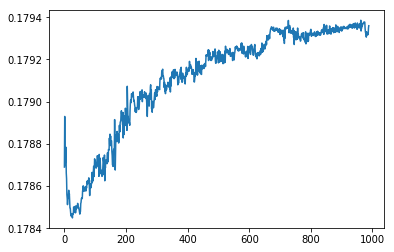

In [33]:
best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]
# best_trial = 1
T = T_all_trials[best_trial]
scores = scores_all_trials[best_trial]
print 'Best trial:', best_trial
print max(scores), scores[-1]

print T.reshape((3,4))
plt.figure();
plt.plot(scores);
plt.show();

In [34]:
label_mapping_m2f

{1: 5}

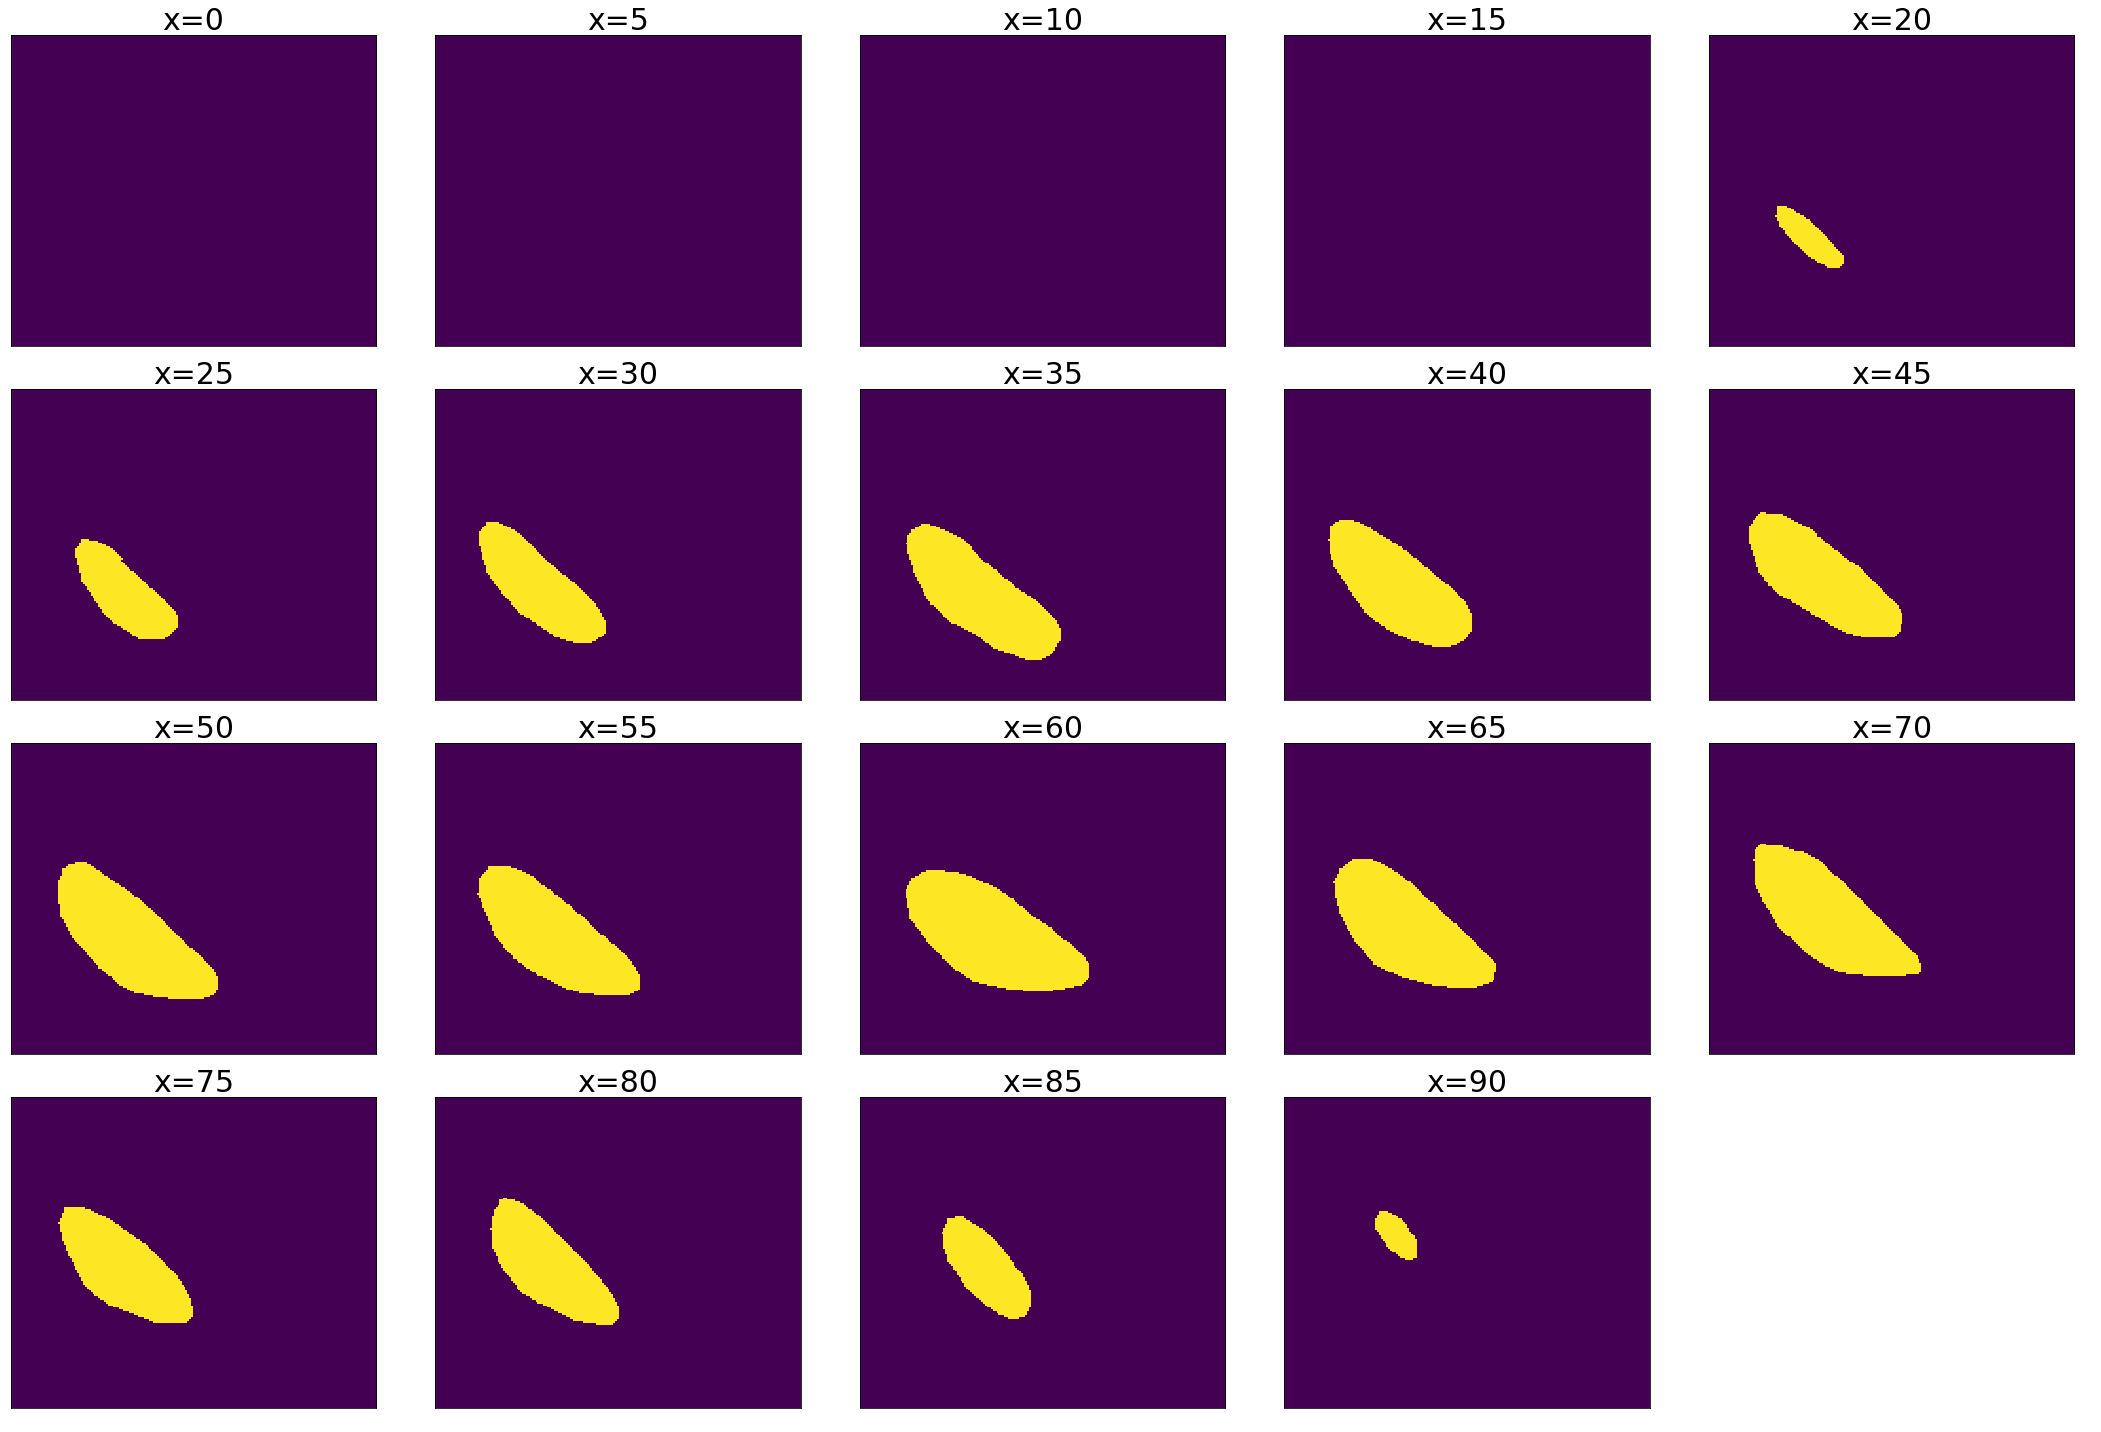

In [35]:
display_volume_sections(volume_fixed[5], start_level=0, every=5, direction='x')

In [36]:
local_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
(T, 
  aligner.centroid_m, aligner.centroid_f,
  aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
  aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

# local_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# ([1,0,0,0,0,1,0,0,0,0,1,0], 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

In [37]:
# Transform moving volume, sided, without surround

# structure = '3N_L'

# vol_m = DataManager.load_original_volume(stack=stack_moving, structure=structure, downscale=32)

vol_m = volume_moving[structure_to_label_moving[structure]]

volume_m_alignedTo_f, volume_m_alignedTo_f_bbox = \
transform_volume_v2(vol=vol_m, tf_params=local_params, centroid_m=centroid_m, centroid_f=centroid_f)

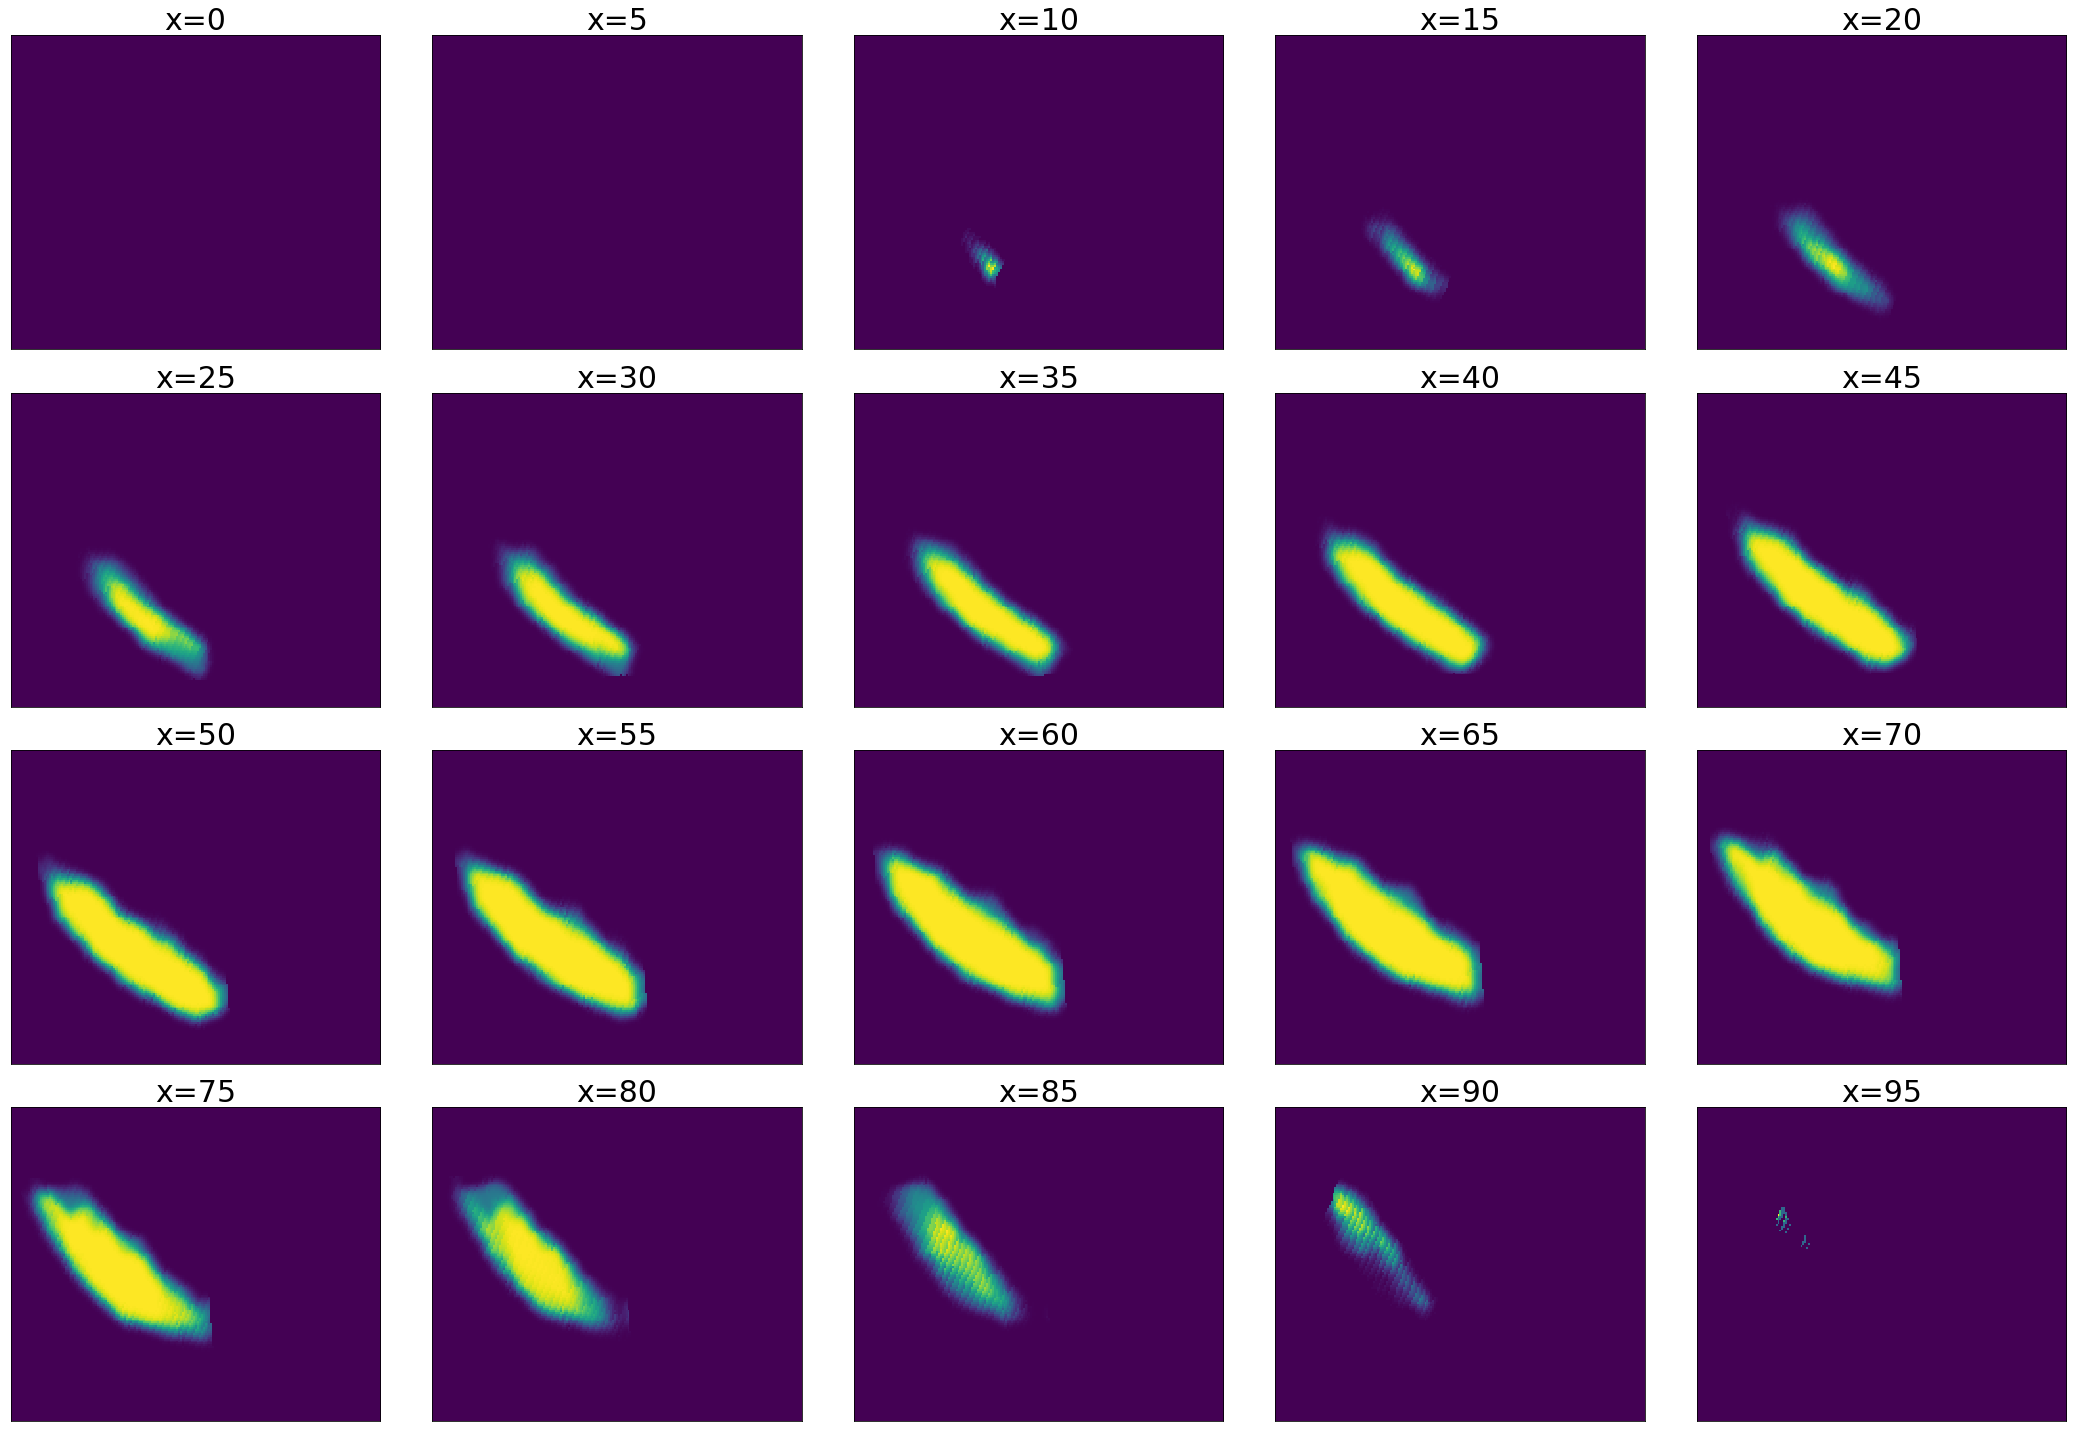

In [38]:
display_volume_sections(crop_and_pad_volume(volume_m_alignedTo_f, in_bbox=volume_m_alignedTo_f_bbox,
                                           out_bbox=(0, xdim_f-1, 0, ydim_f-1, 0, zdim_f-1)), 
                        start_level=0,
                       direction='x')